## 生成对抗网络七日打卡营    课程链接: [https://aistudio.baidu.com/aistudio/course/introduce/16651](https://aistudio.baidu.com/aistudio/course/introduce/16651)

## AI Studio ID: FutureSI

## 将第一节课实践的DCGAN代码改成lsgan的损失函数

可以看下有提示的地方。

In [ ]:
#导入一些必要的包
import os
import random
import paddle 
import paddle.nn as nn
import paddle.optimizer as optim
import paddle.vision.datasets as dset
import paddle.vision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
dataset = paddle.vision.datasets.MNIST(mode='train', 
                                        transform=transforms.Compose([
                                        # resize ->(32,32)
                                        transforms.Resize((32,32)),
                                        # 归一化到-1~1
                                        transforms.Normalize([127.5], [127.5])
                                    ]))

dataloader = paddle.io.DataLoader(dataset, batch_size=32,
                                  shuffle=True, num_workers=4)

In [ ]:
#参数初始化的模块
@paddle.no_grad()
def normal_(x, mean=0., std=1.):
    temp_value = paddle.normal(mean, std, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def uniform_(x, a=-1., b=1.):
    temp_value = paddle.uniform(min=a, max=b, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def constant_(x, value):
    temp_value = paddle.full(x.shape, value, x.dtype)
    x.set_value(temp_value)
    return x

def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight, 1.0, 0.02)
        constant_(m.bias, 0)

In [ ]:
# Generator Code
class Generator(nn.Layer):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input is Z, [B, 100, 1, 1] -> [B, 64 * 4, 4, 4]
            nn.Conv2DTranspose(100, 64 * 4, 4, 1, 0, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.ReLU(True),
            # state size. [B, 64 * 4, 4, 4] -> [B, 64 * 2, 8, 8]
            nn.Conv2DTranspose(64 * 4, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.ReLU(True),
            # state size. [B, 64 * 2, 8, 8] -> [B, 64, 16, 16]
            nn.Conv2DTranspose( 64 * 2, 64, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64),
            nn.ReLU(True),
            # state size. [B, 64, 16, 16] -> [B, 1, 32, 32]
            nn.Conv2DTranspose( 64, 1, 4, 2, 1, bias_attr=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


netG = Generator()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): Conv2DTranspose(100, 256, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU(name=True)
    (3): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (4): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (5): ReLU(name=True)
    (6): Conv2DTranspose(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (7): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (8): ReLU(name=True)
    (9): Conv2DTranspose(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Layer):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(

            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, 4, 2, 1, bias_attr=False),
            nn.LeakyReLU(0.2),

            # state size. [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.LeakyReLU(0.2),

            # state size. [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(64 * 2, 64 * 4, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.LeakyReLU(0.2),

            # state size. [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(64 * 4, 1, 4, 1, 0, bias_attr=False),
            # 这里为需要改变的地方
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.dis(x)

# WGAN不适用BN层,所以去掉了判别器中所有的BN层
class Discriminator_WGANGP(nn.Layer):
    def __init__(self,):
        super(Discriminator_WGANGP, self).__init__()
        self.dis = nn.Sequential(

            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, 4, 2, 1, bias_attr=False),
            nn.LeakyReLU(0.2),

            # state size. [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 64 * 2, 4, 2, 1, bias_attr=False),
            # nn.BatchNorm2D(64 * 2),
            nn.LeakyReLU(0.2),

            # state size. [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(64 * 2, 64 * 4, 4, 2, 1, bias_attr=False),
            # nn.BatchNorm2D(64 * 4),
            nn.LeakyReLU(0.2),

            # state size. [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(64 * 4, 1, 4, 1, 0, bias_attr=False),
            # 这里为需要改变的地方
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.dis(x)

netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2D(1, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (3): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (6): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2D(256, 1, kernel_size=[4, 4], data_format=NCHW)
  )
)


In [ ]:
# 定义各种损失函数
class GanLoss():
    def __init__(self, loss_name='vanilla_gan_loss'):
        self.loss_name = loss_name
    
    def __call__(self, logit, label):
        # 经典GAN的loss，即交叉熵损失（Cross Entrofy Loss)
        if self.loss_name == 'vanilla_gan_loss':
            predict = nn.Sigmoid()(logit) # 经典gan使用sigmoid激活将预测值缩放到（0，1）区间
            predict = 1. - predict # 在使用 -log trick 后,仍然使判别器判断真图片时输出趋近1,也可以不加这一行代码
            loss = -paddle.log(paddle.abs(label - predict))
        # 最小二乘损失（Least Square Loss）
        elif self.loss_name == 'ls_gan_loss':
            predict = logit
            loss = (label - predict) ** 2
        # SAGAN用过的合页损失（hinge Loss），这是一种最大分类间隔损失。
        elif self.loss_name == 'hinge_loss':
            if paddle.mean(label).numpy()[0] == .0: # 使真假标签从1和0，转化为为1和-1。
                label -= 1.
            predict = logit
            loss = nn.ReLU()(1.0 - predict * label)
        # 二分类交叉熵损失（Binary Cross Entropy Loss）
        elif self.loss_name == 'BCE_loss':
            predict = nn.functional.sigmoid(logit)
            loss = nn.BCELoss()(predict, label)
        # WGAN损失（Wasserstein GAN Loss），需要判别器满足Lipchits连续。
        # 如果判别器不使用普归一化（以保证Lipchits连续），就要加入梯度惩罚项。
        # 梯度惩罚项要加在判别器判别真假数据损失的和上，所以判别器要一起更新判别真假数据的参数
        elif self.loss_name == 'wgan_loss' or self.loss_name == 'wgan_gp_loss':
            if paddle.mean(label).numpy()[0] == .0: # 使真假标签从1和0，转化为为1和-1。
                label -= 1.
            predict = logit
            loss = -predict * label

        avg_loss = paddle.mean(loss) # 计算loss均值
        return avg_loss
    
    # 计算wgan-gp的梯度惩罚项
    def gradient_penalty(self, real_data, fake_data, discriminator):
        alpha = paddle.uniform(real_data.shape, min=0, max=1)
        interpolates = alpha * fake_data + (1 - alpha) * real_data
        interpolates.stop_gradient = False
        predict = discriminator(interpolates)
        gradient = paddle.grad(
            outputs=[predict],
            inputs=[interpolates],
            grad_outputs=paddle.ones_like(predict),
            create_graph=True,
            retain_graph=True,
            only_inputs=True)[0]
        gradient_penalty = ((gradient.norm(2, axis=1) - 1.) ** 2).mean()
        return gradient_penalty



In [ ]:
# Initialize BCELoss function
# 这里为需要改变的地方
# loss = GanLoss(loss_name='vanilla_gan_loss')
loss = GanLoss(loss_name='ls_gan_loss')
# loss = GanLoss(loss_name='hinge_loss')
# loss = GanLoss(loss_name='BCE_loss')
# loss = GanLoss(loss_name='wgan_gp_loss')

#WGAN-GP要使用不带BN层的判别器
if loss.loss_name == 'wgan_gp_loss':
    netD = Discriminator_WGANGP()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = paddle.randn([32, 100, 1, 1], dtype='float32')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated 

Epoch ID=0 Batch ID=0 

 D-Loss=5.04497766494751 G-Loss=0.5608330965042114


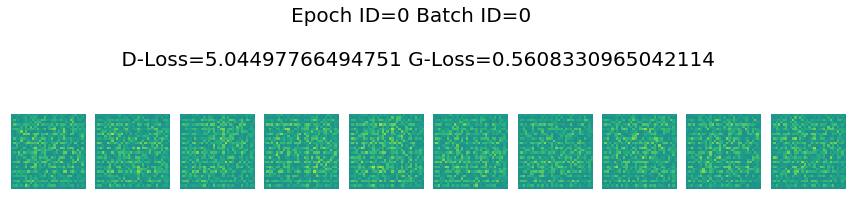

Epoch ID=0 Batch ID=100 

 D-Loss=2.161024570465088 G-Loss=10.497177124023438


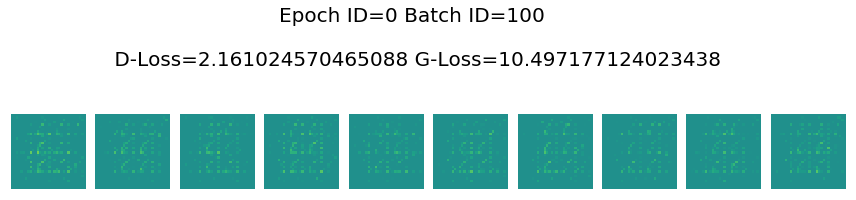

Epoch ID=0 Batch ID=200 

 D-Loss=0.6219617128372192 G-Loss=4.190850257873535


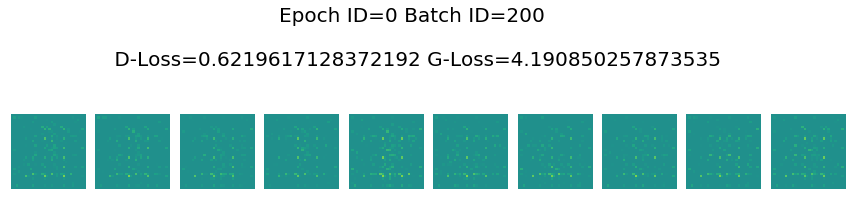

Epoch ID=0 Batch ID=300 

 D-Loss=0.29803788661956787 G-Loss=1.7316131591796875


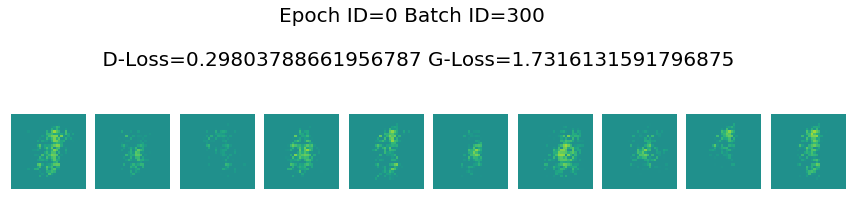

Epoch ID=0 Batch ID=400 

 D-Loss=0.23612788319587708 G-Loss=1.2856438159942627


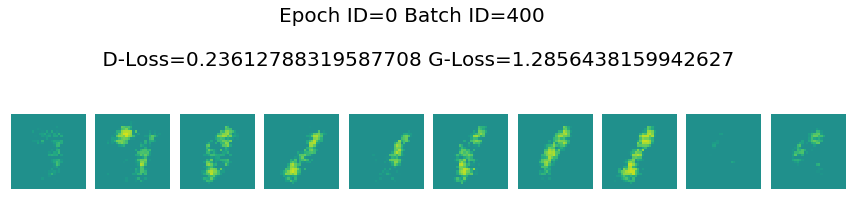

Epoch ID=0 Batch ID=500 

 D-Loss=0.6803880333900452 G-Loss=1.9130544662475586


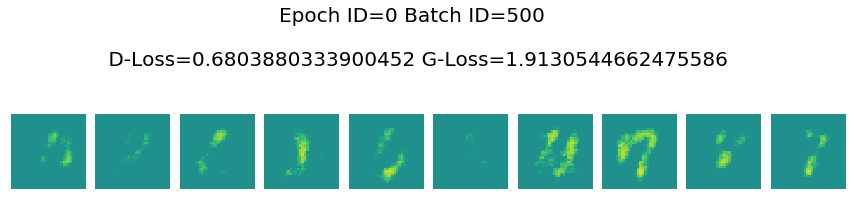

Epoch ID=0 Batch ID=600 

 D-Loss=0.1720956563949585 G-Loss=0.7700108289718628


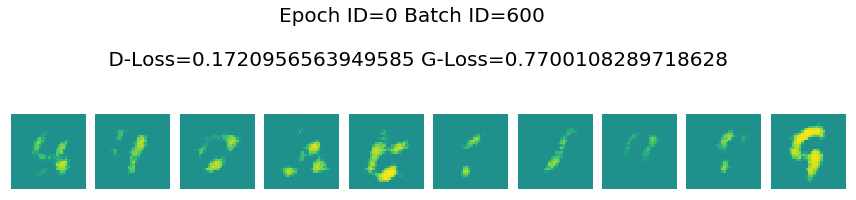

Epoch ID=0 Batch ID=700 

 D-Loss=0.18788322806358337 G-Loss=0.6073373556137085


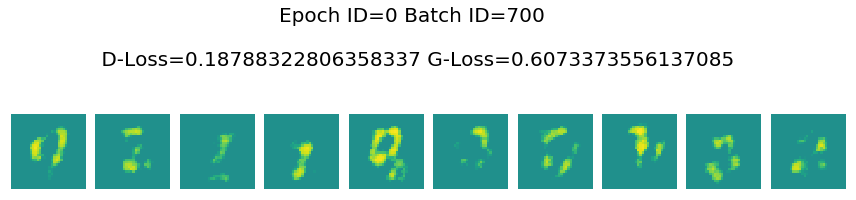

Epoch ID=0 Batch ID=800 

 D-Loss=0.2288643717765808 G-Loss=0.44335848093032837


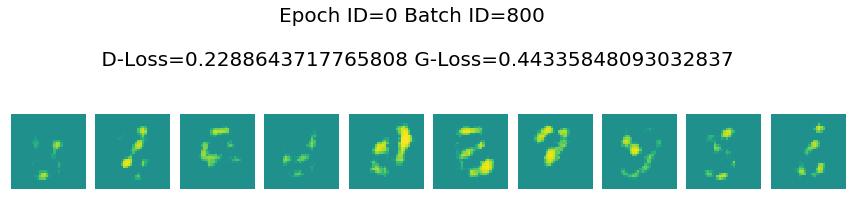

Epoch ID=0 Batch ID=900 

 D-Loss=0.10544487088918686 G-Loss=0.8141986131668091


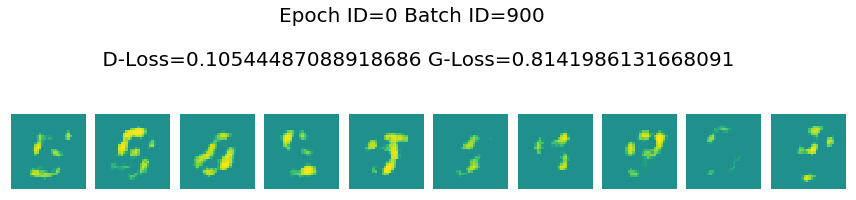

Epoch ID=0 Batch ID=1000 

 D-Loss=0.17518961429595947 G-Loss=1.3648207187652588


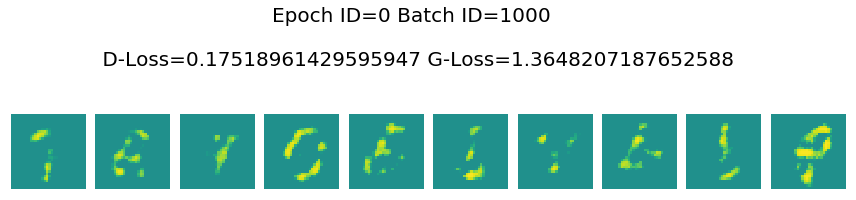

Epoch ID=0 Batch ID=1100 

 D-Loss=0.08927808701992035 G-Loss=0.8487526178359985


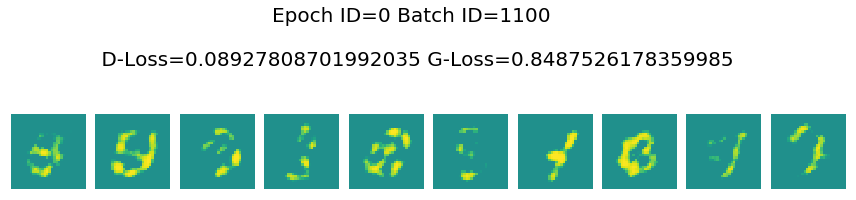

Epoch ID=0 Batch ID=1200 

 D-Loss=0.19180478155612946 G-Loss=1.2713603973388672


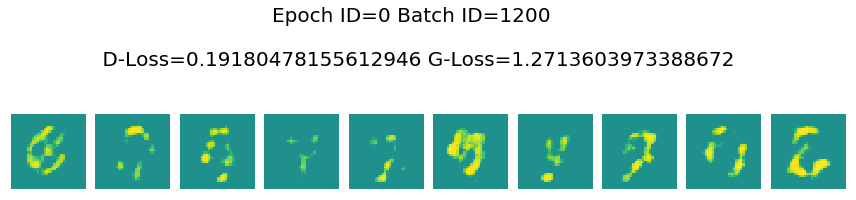

Epoch ID=0 Batch ID=1300 

 D-Loss=0.1242980808019638 G-Loss=0.6695355772972107


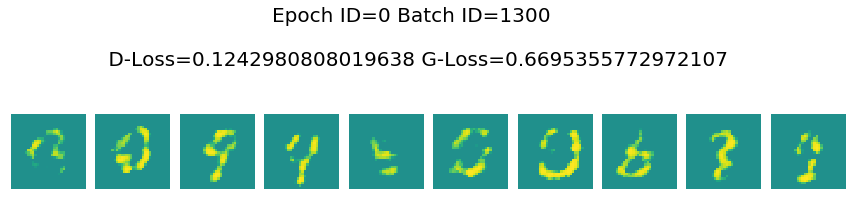

Epoch ID=0 Batch ID=1400 

 D-Loss=0.046568967401981354 G-Loss=1.115433931350708


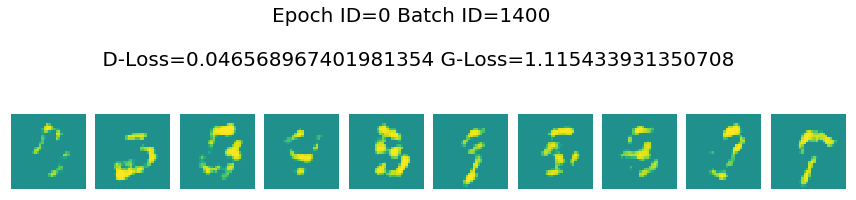

Epoch ID=0 Batch ID=1500 

 D-Loss=0.05378667265176773 G-Loss=0.746168851852417


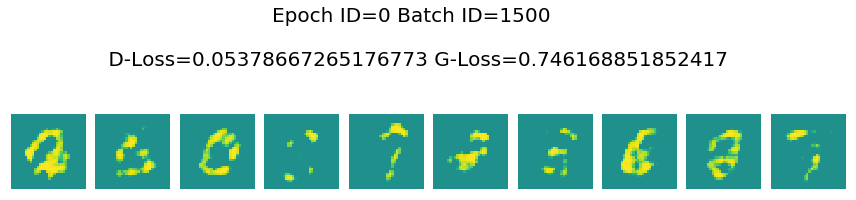

Epoch ID=0 Batch ID=1600 

 D-Loss=0.10941966623067856 G-Loss=1.110595941543579


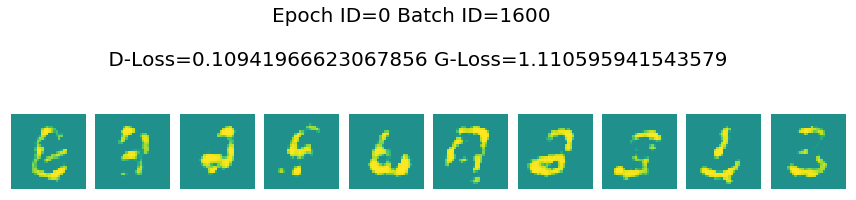

Epoch ID=0 Batch ID=1700 

 D-Loss=0.0894971489906311 G-Loss=1.1043437719345093


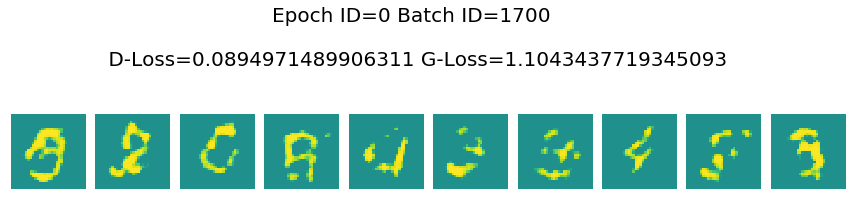

Epoch ID=0 Batch ID=1800 

 D-Loss=0.11541061103343964 G-Loss=1.04183030128479


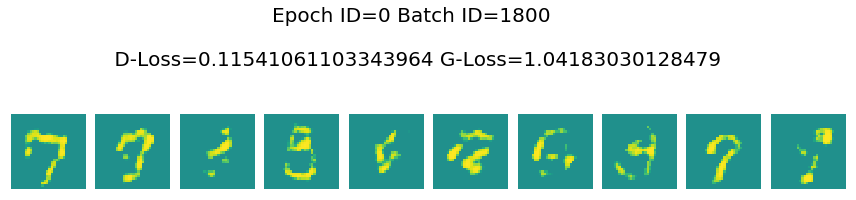

Epoch ID=1 Batch ID=0 

 D-Loss=0.38260358572006226 G-Loss=0.2852368652820587


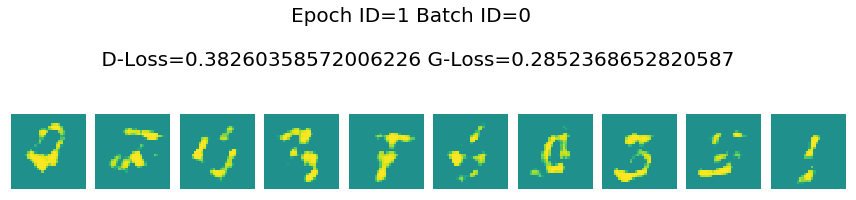

Epoch ID=1 Batch ID=100 

 D-Loss=0.13782420754432678 G-Loss=0.7587824463844299


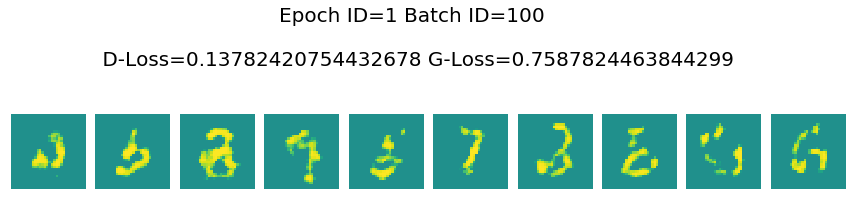

Epoch ID=1 Batch ID=200 

 D-Loss=0.11594707518815994 G-Loss=0.6364657878875732


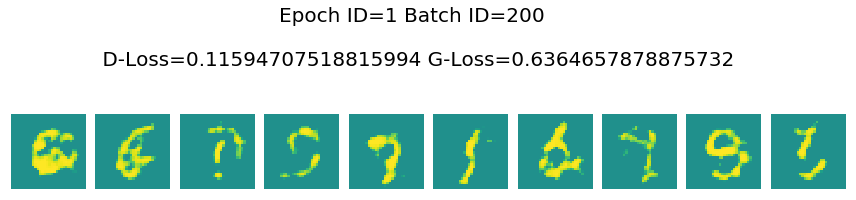

Epoch ID=1 Batch ID=300 

 D-Loss=0.06504204869270325 G-Loss=0.888960599899292


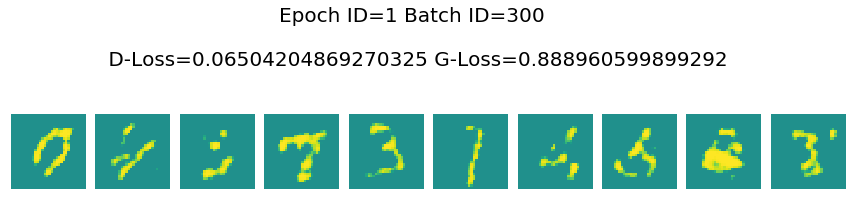

Epoch ID=1 Batch ID=400 

 D-Loss=7.257388591766357 G-Loss=0.16616518795490265


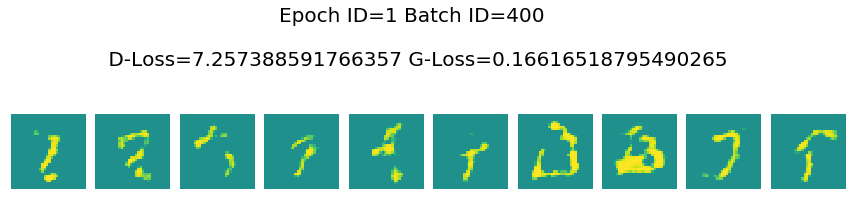

Epoch ID=1 Batch ID=500 

 D-Loss=0.3217092454433441 G-Loss=0.6301528215408325


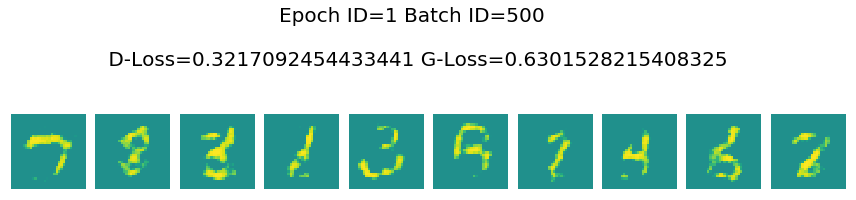

Epoch ID=1 Batch ID=600 

 D-Loss=0.3927536606788635 G-Loss=0.8364446759223938


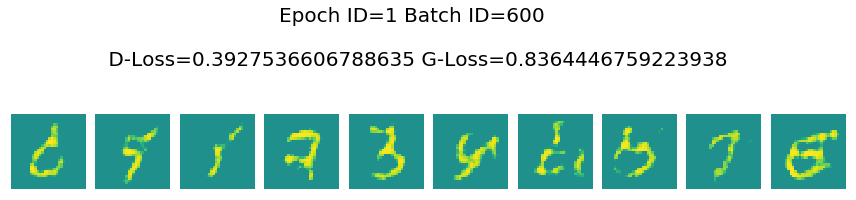

Epoch ID=1 Batch ID=700 

 D-Loss=0.1484062373638153 G-Loss=0.5591320395469666


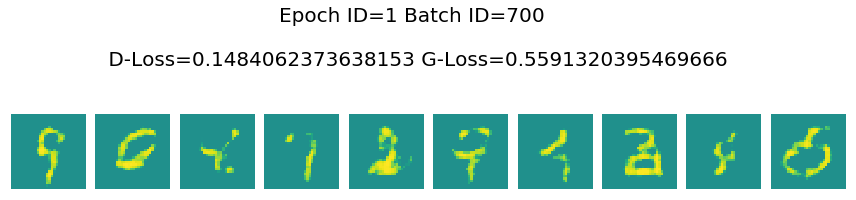

Epoch ID=1 Batch ID=800 

 D-Loss=0.22991876304149628 G-Loss=0.8803406953811646


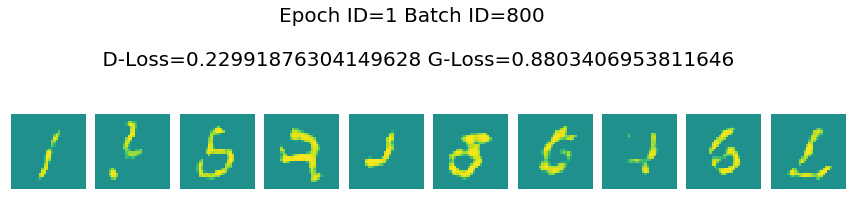

Epoch ID=1 Batch ID=900 

 D-Loss=0.12679366767406464 G-Loss=0.4775621294975281


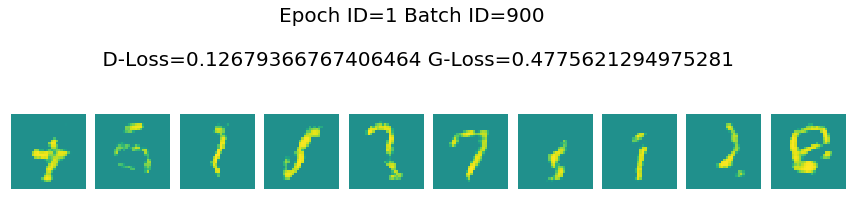

Epoch ID=1 Batch ID=1000 

 D-Loss=0.1763460636138916 G-Loss=0.8487426042556763


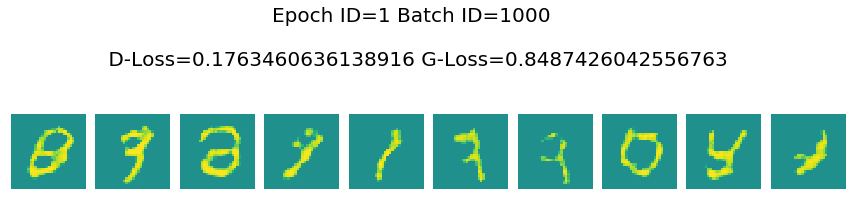

Epoch ID=1 Batch ID=1100 

 D-Loss=0.2382943481206894 G-Loss=0.5436795949935913


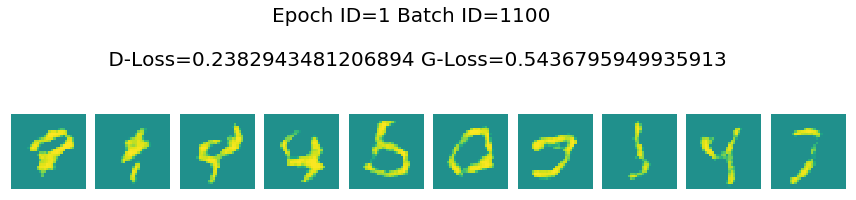

Epoch ID=1 Batch ID=1200 

 D-Loss=0.1024993434548378 G-Loss=0.798112690448761


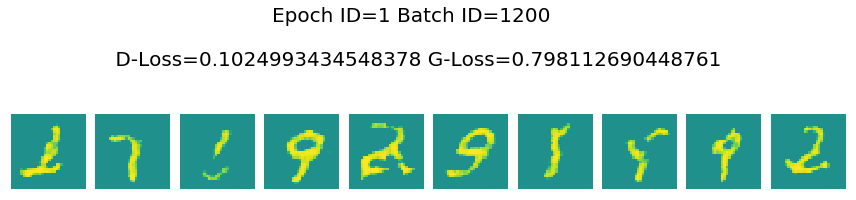

Epoch ID=1 Batch ID=1300 

 D-Loss=0.10228783637285233 G-Loss=0.8075820207595825


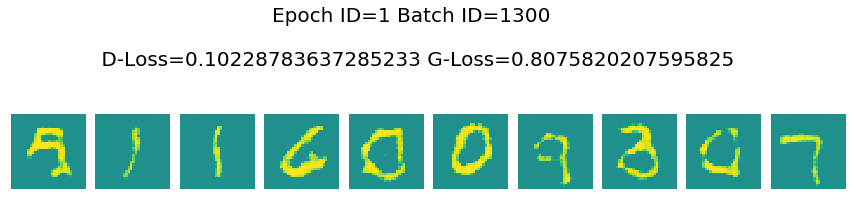

Epoch ID=1 Batch ID=1400 

 D-Loss=0.478461891412735 G-Loss=1.1082937717437744


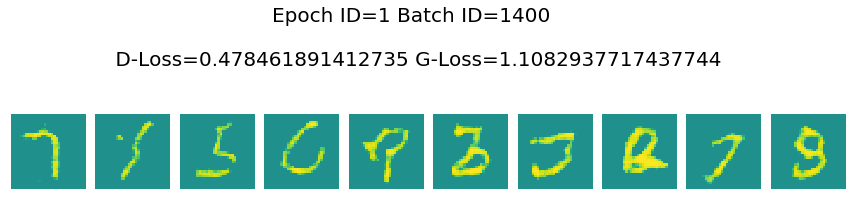

Epoch ID=1 Batch ID=1500 

 D-Loss=0.16808071732521057 G-Loss=0.5736116170883179


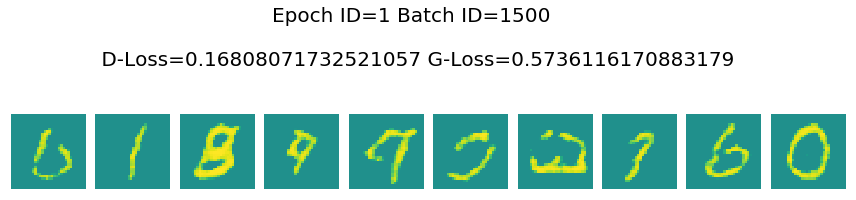

Epoch ID=1 Batch ID=1600 

 D-Loss=0.30765658617019653 G-Loss=1.3242583274841309


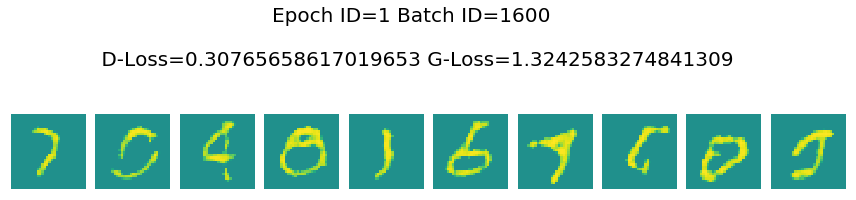

Epoch ID=1 Batch ID=1700 

 D-Loss=0.5017849206924438 G-Loss=0.4058184325695038


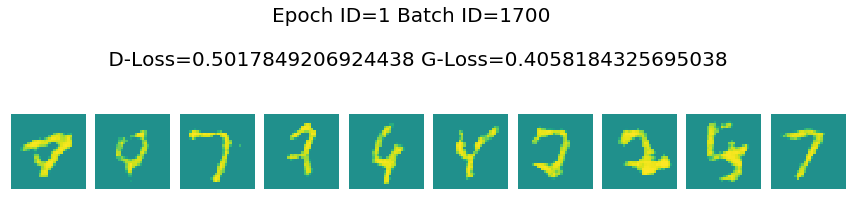

Epoch ID=1 Batch ID=1800 

 D-Loss=0.34154677391052246 G-Loss=0.48414525389671326


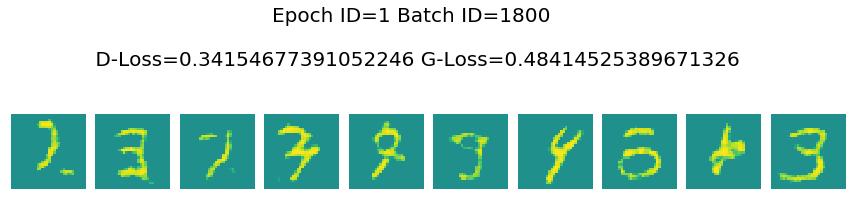

Epoch ID=2 Batch ID=0 

 D-Loss=0.3132688105106354 G-Loss=0.6804428100585938


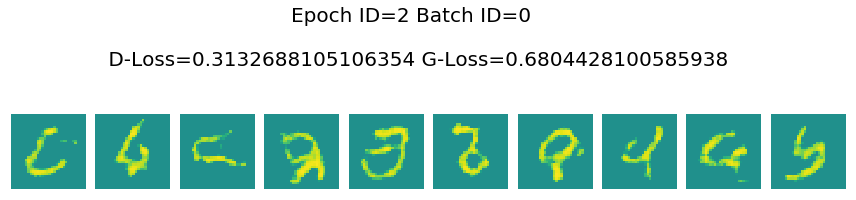

Epoch ID=2 Batch ID=100 

 D-Loss=0.4688854217529297 G-Loss=0.19353878498077393


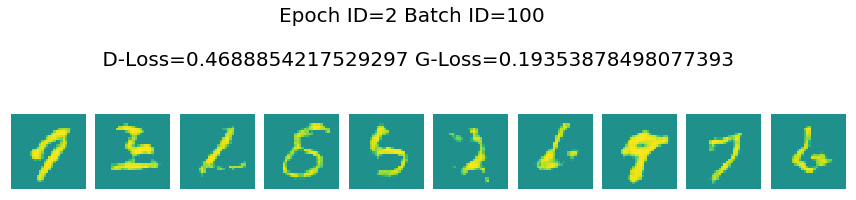

Epoch ID=2 Batch ID=200 

 D-Loss=0.13668924570083618 G-Loss=0.6124464273452759


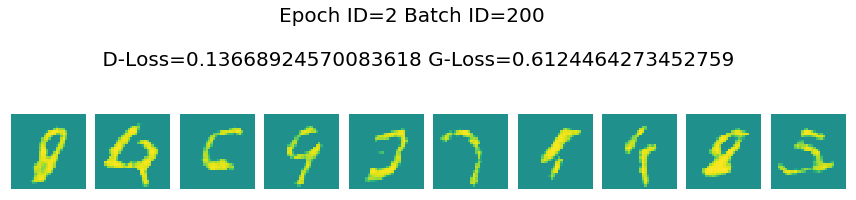

Epoch ID=2 Batch ID=300 

 D-Loss=0.19228620827198029 G-Loss=1.2071952819824219


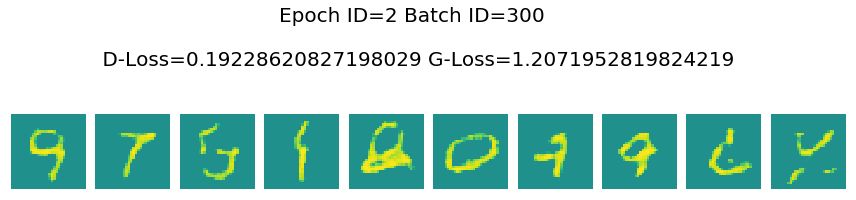

Epoch ID=2 Batch ID=400 

 D-Loss=0.2435608208179474 G-Loss=0.7979736328125


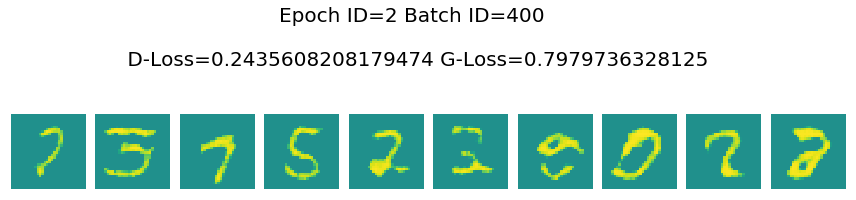

Epoch ID=2 Batch ID=500 

 D-Loss=0.08673223853111267 G-Loss=1.1078667640686035


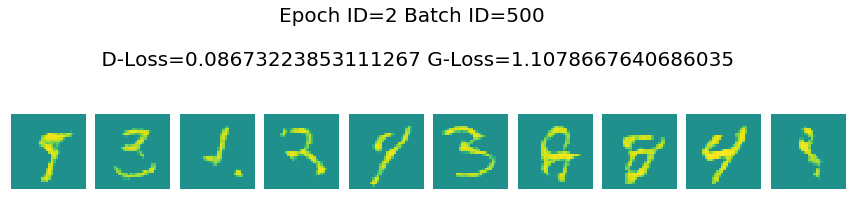

Epoch ID=2 Batch ID=600 

 D-Loss=0.2828389108181 G-Loss=1.0894181728363037


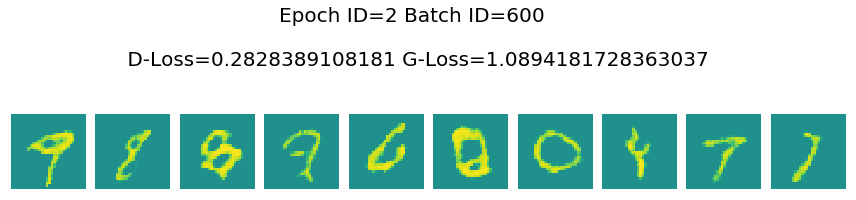

Epoch ID=2 Batch ID=700 

 D-Loss=0.34036409854888916 G-Loss=0.7706056237220764


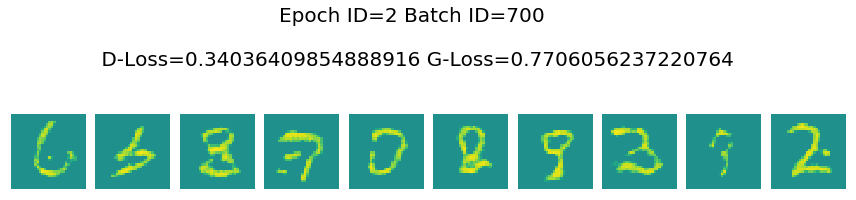

Epoch ID=2 Batch ID=800 

 D-Loss=0.3502025008201599 G-Loss=1.3930147886276245


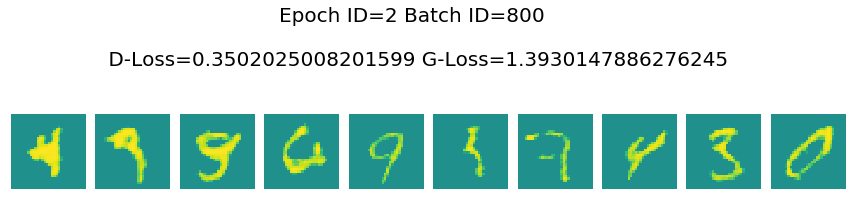

Epoch ID=2 Batch ID=900 

 D-Loss=0.11077467352151871 G-Loss=0.7703893184661865


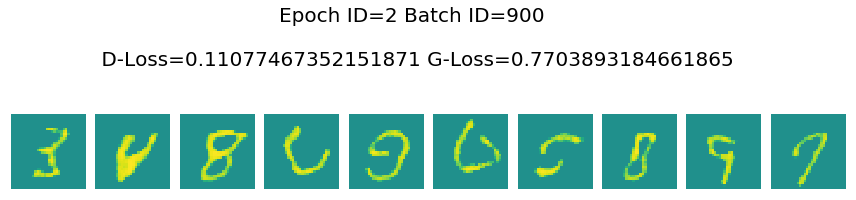

Epoch ID=2 Batch ID=1000 

 D-Loss=0.12828275561332703 G-Loss=0.8316997289657593


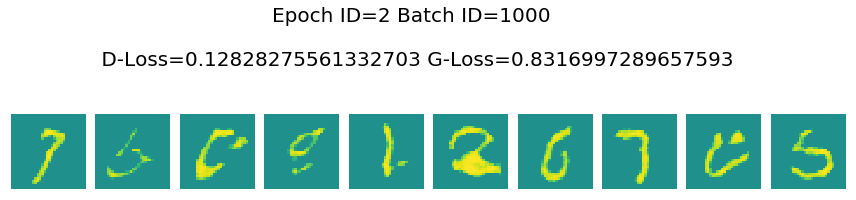

Epoch ID=2 Batch ID=1100 

 D-Loss=0.5073588490486145 G-Loss=0.2938632667064667


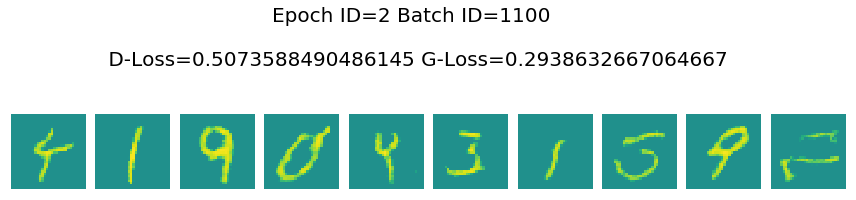

Epoch ID=2 Batch ID=1200 

 D-Loss=0.13699200749397278 G-Loss=0.8232729434967041


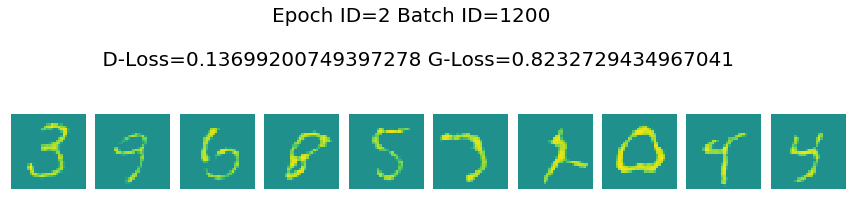

Epoch ID=2 Batch ID=1300 

 D-Loss=0.16714748740196228 G-Loss=0.6425696611404419


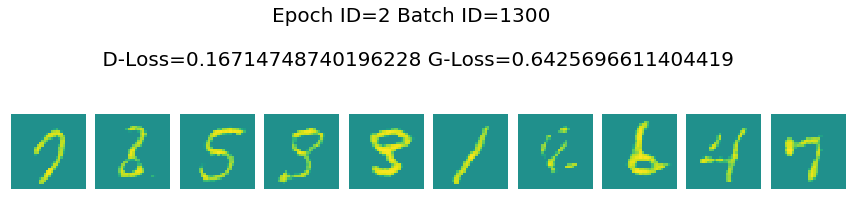

Epoch ID=2 Batch ID=1400 

 D-Loss=0.2733021080493927 G-Loss=1.1531000137329102


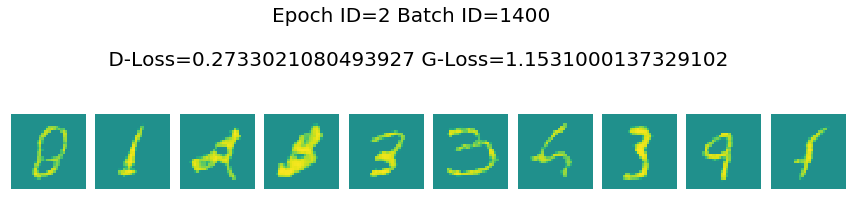

Epoch ID=2 Batch ID=1500 

 D-Loss=0.13286751508712769 G-Loss=1.22639799118042


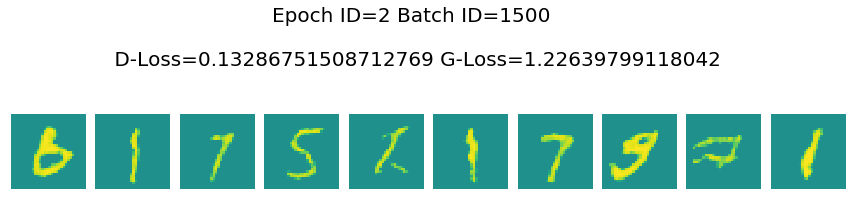

Epoch ID=2 Batch ID=1600 

 D-Loss=0.1484602987766266 G-Loss=0.4866873621940613


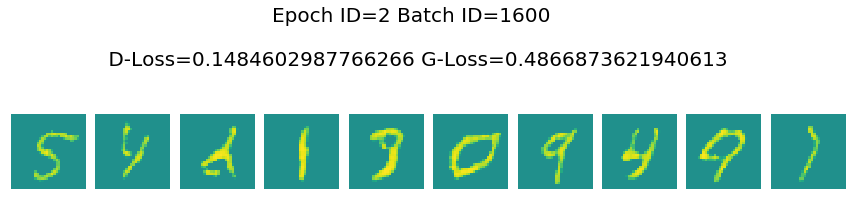

Epoch ID=2 Batch ID=1700 

 D-Loss=0.2299444079399109 G-Loss=1.3144460916519165


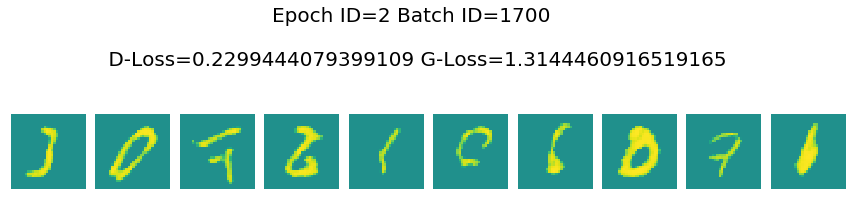

Epoch ID=2 Batch ID=1800 

 D-Loss=0.15369369089603424 G-Loss=1.019073724746704


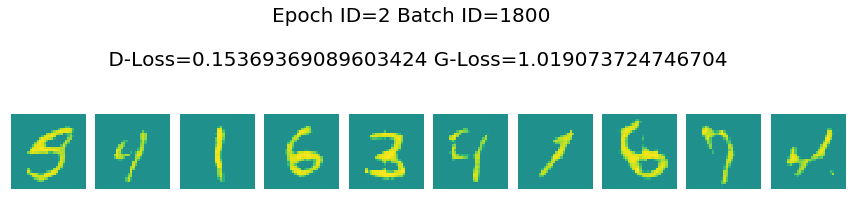

Epoch ID=3 Batch ID=0 

 D-Loss=0.3136002719402313 G-Loss=0.5062393546104431


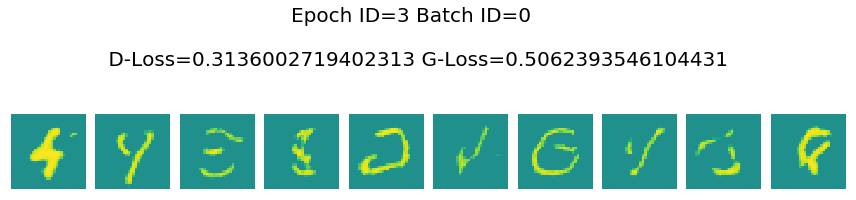

Epoch ID=3 Batch ID=100 

 D-Loss=0.15662910044193268 G-Loss=0.5850048065185547


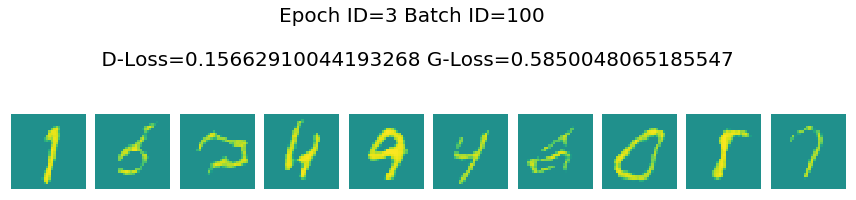

Epoch ID=3 Batch ID=200 

 D-Loss=0.09504605084657669 G-Loss=0.674252986907959


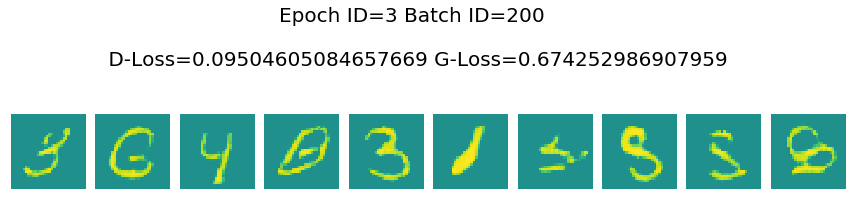

Epoch ID=3 Batch ID=300 

 D-Loss=0.2550813555717468 G-Loss=0.5893449783325195


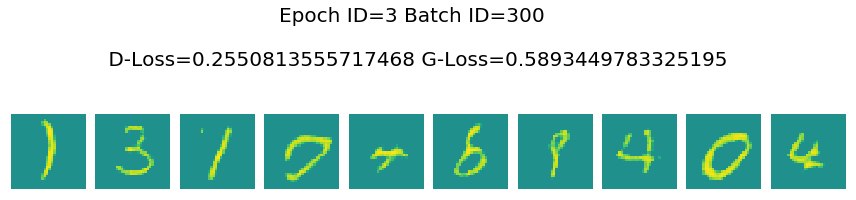

Epoch ID=3 Batch ID=400 

 D-Loss=0.08922754973173141 G-Loss=0.8085272312164307


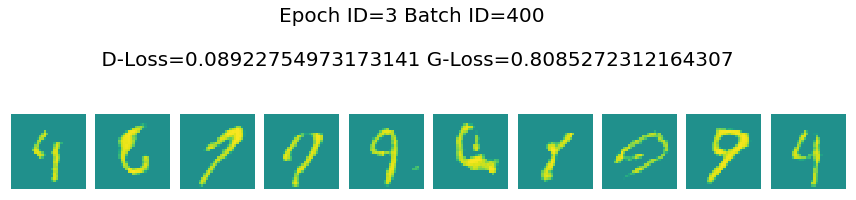

Epoch ID=3 Batch ID=500 

 D-Loss=0.11223912984132767 G-Loss=0.9768810868263245


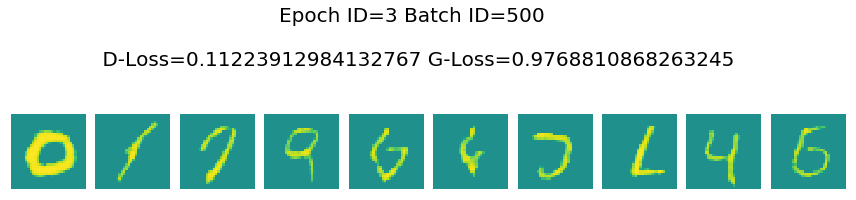

Epoch ID=3 Batch ID=600 

 D-Loss=0.1653214544057846 G-Loss=0.6000053882598877


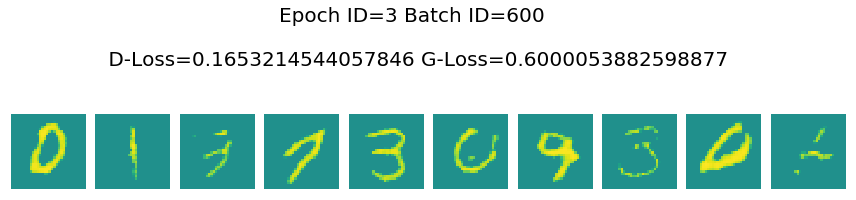

Epoch ID=3 Batch ID=700 

 D-Loss=0.47385698556900024 G-Loss=0.3296961486339569


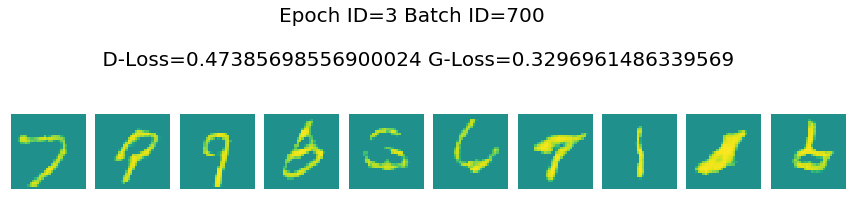

Epoch ID=3 Batch ID=800 

 D-Loss=0.07550429552793503 G-Loss=0.9596997499465942


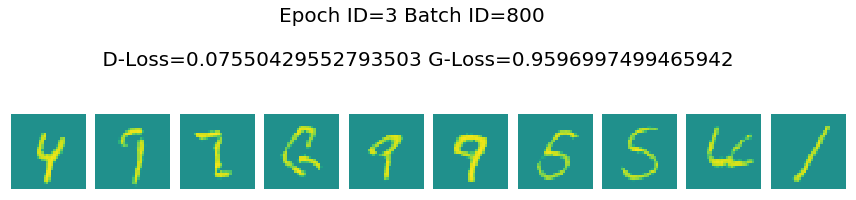

Epoch ID=3 Batch ID=900 

 D-Loss=0.1782243847846985 G-Loss=0.3251741826534271


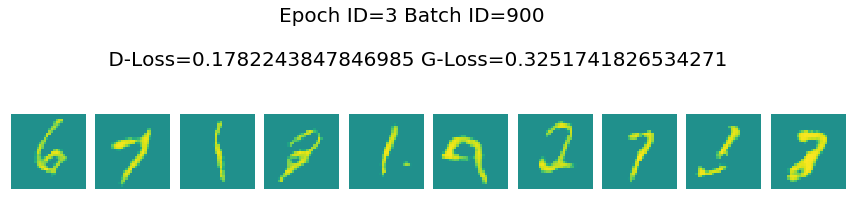

Epoch ID=3 Batch ID=1000 

 D-Loss=0.16717641055583954 G-Loss=1.0660799741744995


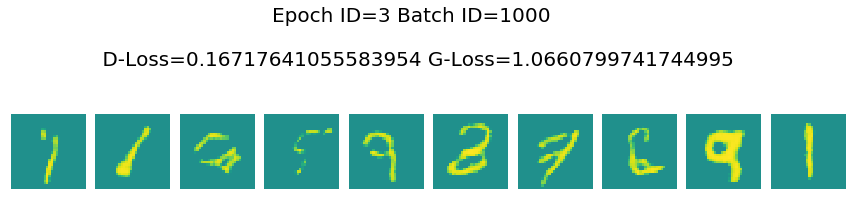

Epoch ID=3 Batch ID=1100 

 D-Loss=0.1258607655763626 G-Loss=0.539906919002533


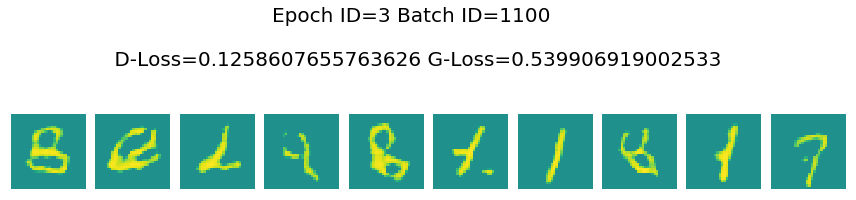

Epoch ID=3 Batch ID=1200 

 D-Loss=0.09081454575061798 G-Loss=1.6926844120025635


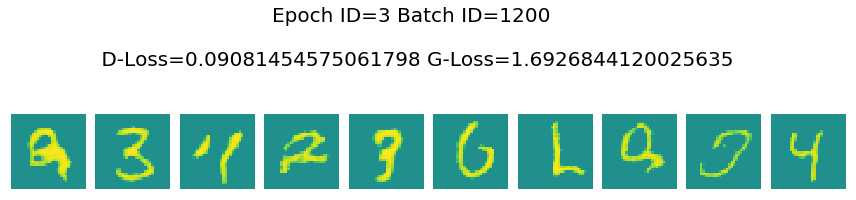

Epoch ID=3 Batch ID=1300 

 D-Loss=0.1315573900938034 G-Loss=0.7494211196899414


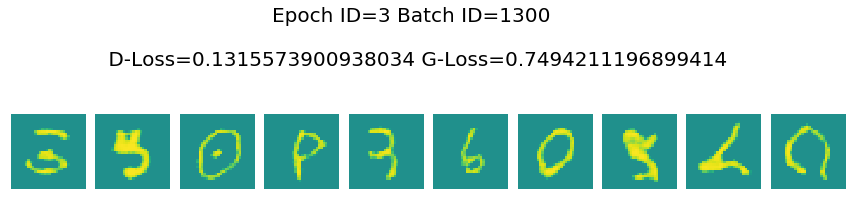

Epoch ID=3 Batch ID=1400 

 D-Loss=0.13647012412548065 G-Loss=0.564439058303833


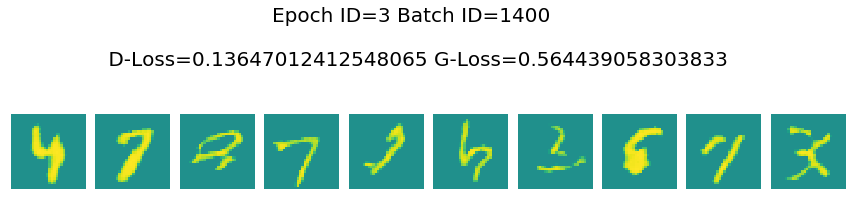

Epoch ID=3 Batch ID=1500 

 D-Loss=0.12520721554756165 G-Loss=0.8152356147766113


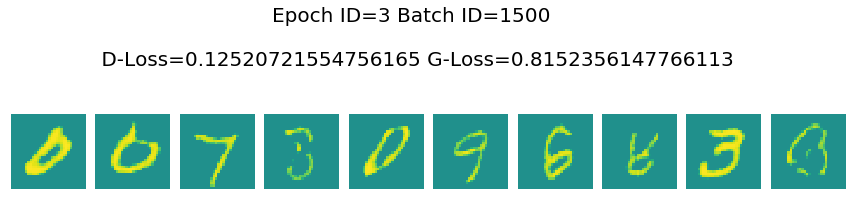

Epoch ID=3 Batch ID=1600 

 D-Loss=0.19462788105010986 G-Loss=1.0476529598236084


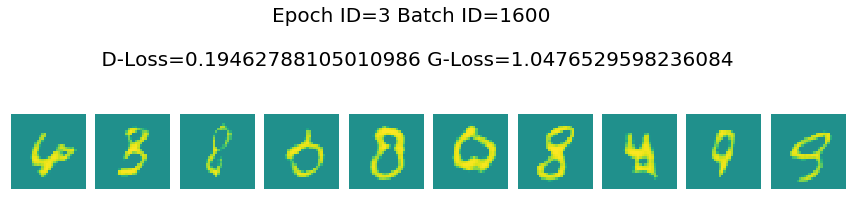

Epoch ID=3 Batch ID=1700 

 D-Loss=0.1607237160205841 G-Loss=0.2872315049171448


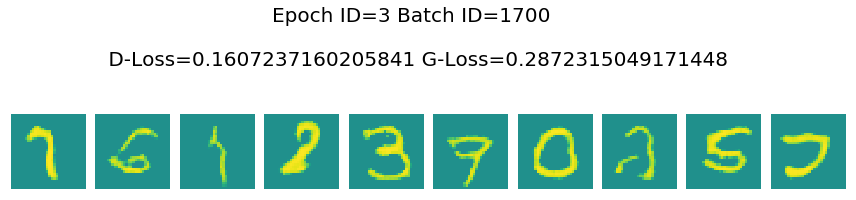

Epoch ID=3 Batch ID=1800 

 D-Loss=0.22210495173931122 G-Loss=0.4762824773788452


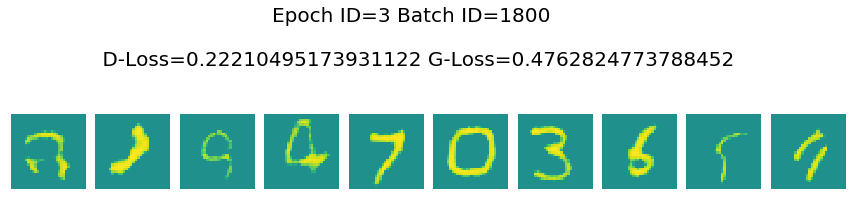

Epoch ID=4 Batch ID=0 

 D-Loss=0.17902813851833344 G-Loss=1.442249059677124


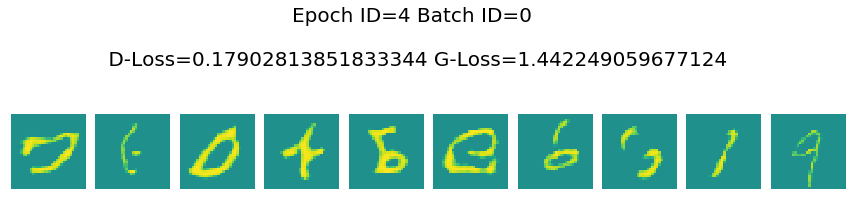

Epoch ID=4 Batch ID=100 

 D-Loss=0.27353551983833313 G-Loss=0.33523422479629517


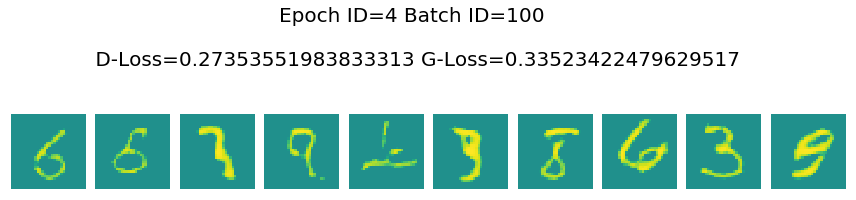

Epoch ID=4 Batch ID=200 

 D-Loss=0.1695835441350937 G-Loss=0.7690236568450928


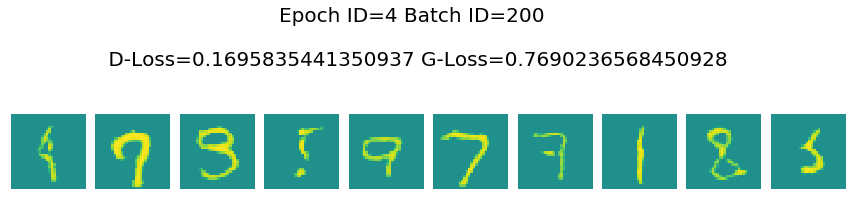

Epoch ID=4 Batch ID=300 

 D-Loss=0.26762300729751587 G-Loss=0.7676246166229248


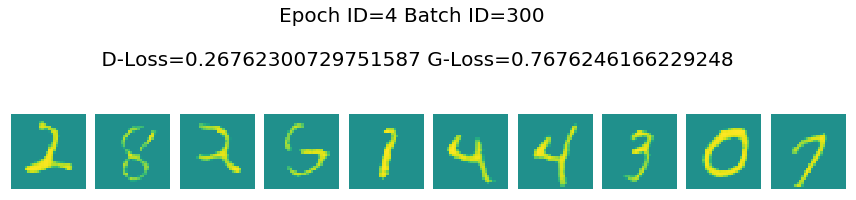

Epoch ID=4 Batch ID=400 

 D-Loss=0.09531114250421524 G-Loss=0.6893037557601929


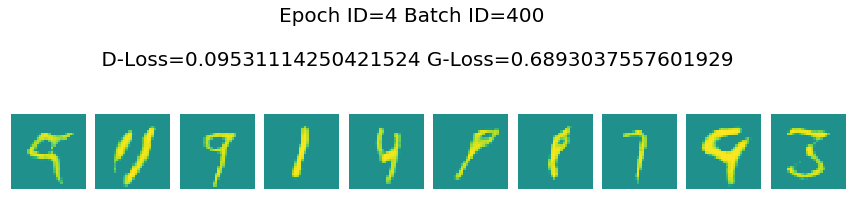

Epoch ID=4 Batch ID=500 

 D-Loss=0.1362980753183365 G-Loss=0.6289165019989014


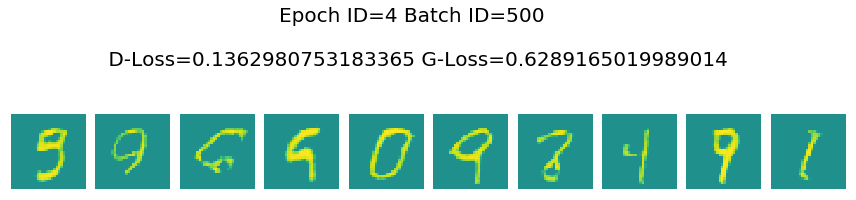

Epoch ID=4 Batch ID=600 

 D-Loss=0.0774226263165474 G-Loss=0.766004741191864


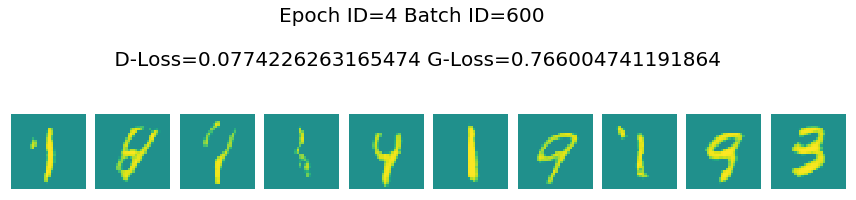

Epoch ID=4 Batch ID=700 

 D-Loss=0.1324203610420227 G-Loss=0.7297719120979309


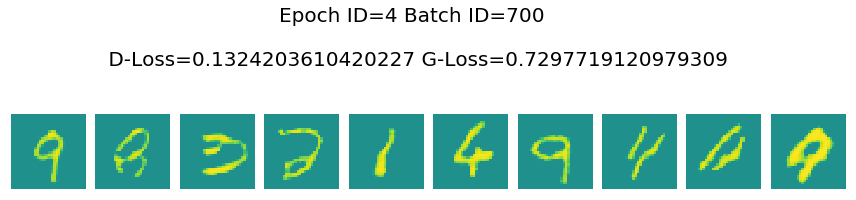

Epoch ID=4 Batch ID=800 

 D-Loss=0.44172218441963196 G-Loss=0.23986151814460754


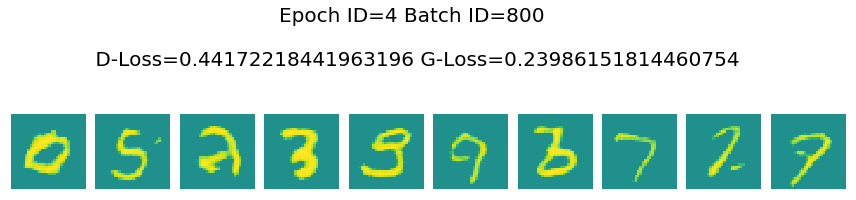

Epoch ID=4 Batch ID=900 

 D-Loss=0.12648014724254608 G-Loss=0.4082743227481842


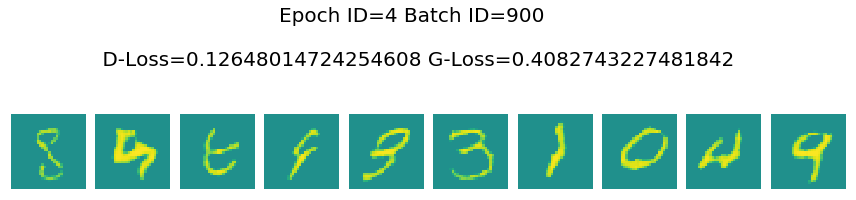

Epoch ID=4 Batch ID=1000 

 D-Loss=0.03735356032848358 G-Loss=0.6472994685173035


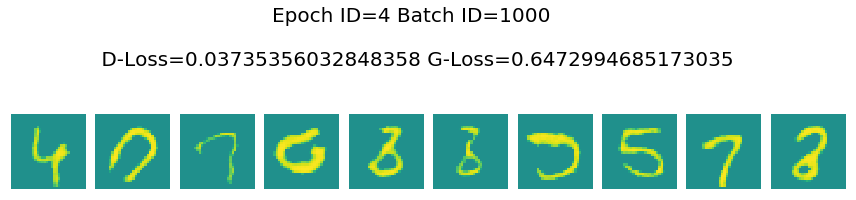

Epoch ID=4 Batch ID=1100 

 D-Loss=0.05551398918032646 G-Loss=1.4095230102539062


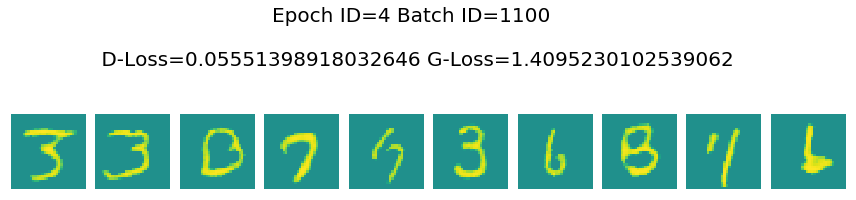

Epoch ID=4 Batch ID=1200 

 D-Loss=0.05592382699251175 G-Loss=1.0041807889938354


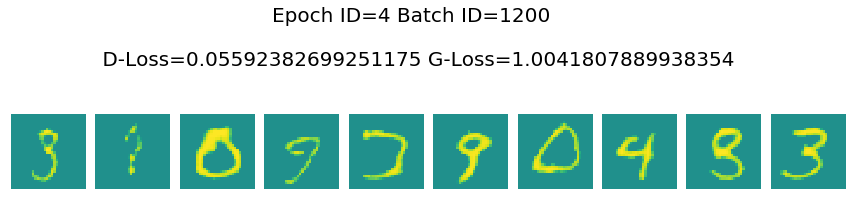

Epoch ID=4 Batch ID=1300 

 D-Loss=0.055383697152137756 G-Loss=0.8392361998558044


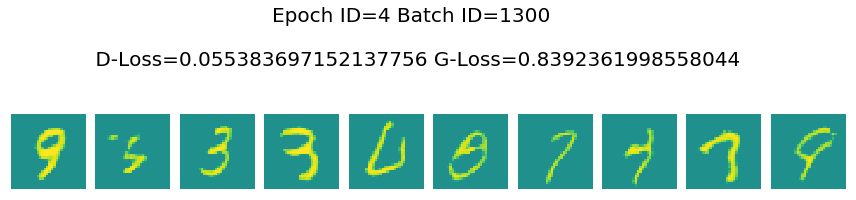

Epoch ID=4 Batch ID=1400 

 D-Loss=0.07068062573671341 G-Loss=1.2654001712799072


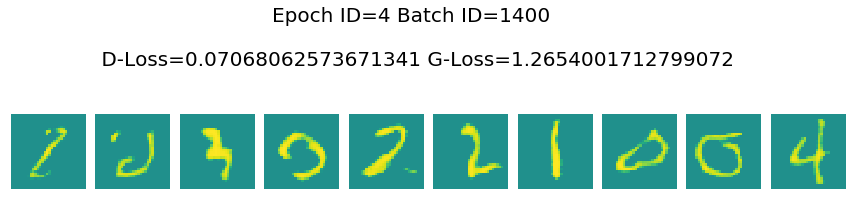

Epoch ID=4 Batch ID=1500 

 D-Loss=0.19290168583393097 G-Loss=0.8178281784057617


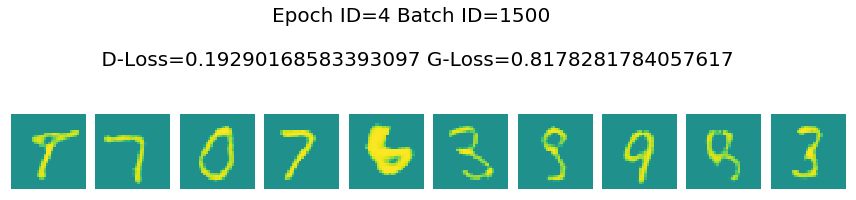

Epoch ID=4 Batch ID=1600 

 D-Loss=0.3029486835002899 G-Loss=1.124666452407837


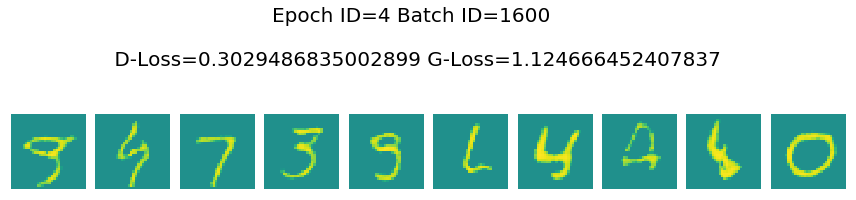

Epoch ID=4 Batch ID=1700 

 D-Loss=0.08096392452716827 G-Loss=1.8585479259490967


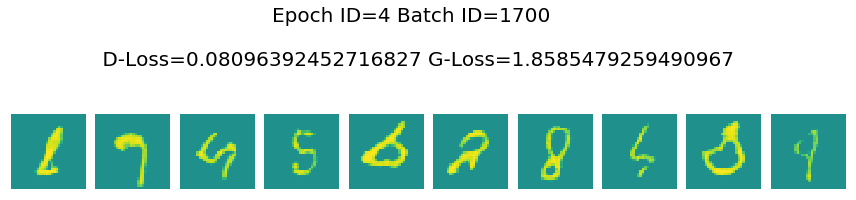

Epoch ID=4 Batch ID=1800 

 D-Loss=0.24552276730537415 G-Loss=0.7756434679031372


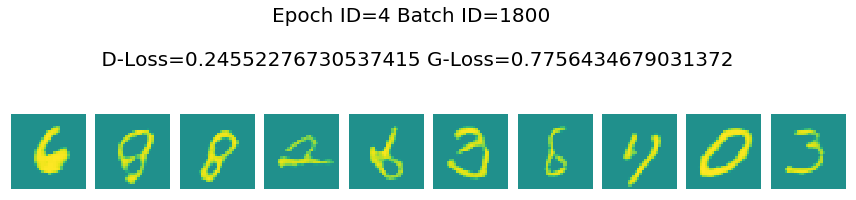

Epoch ID=5 Batch ID=0 

 D-Loss=0.09481160342693329 G-Loss=0.7865884900093079


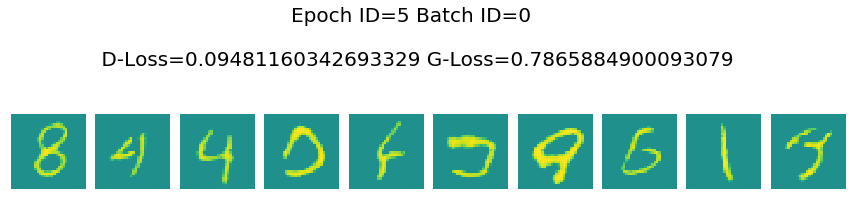

Epoch ID=5 Batch ID=100 

 D-Loss=0.1685687005519867 G-Loss=0.3800446391105652


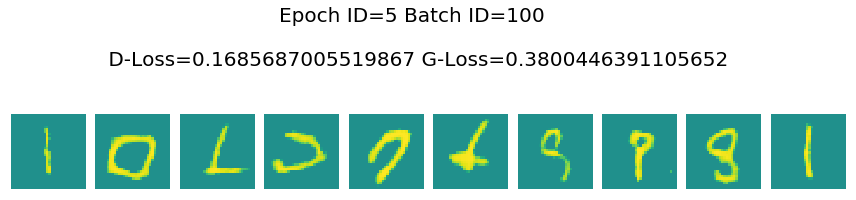

Epoch ID=5 Batch ID=200 

 D-Loss=0.09019249677658081 G-Loss=0.5557892322540283


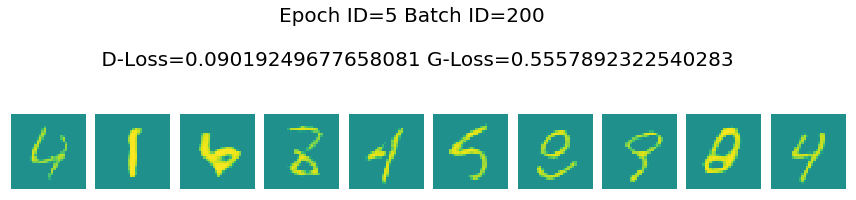

Epoch ID=5 Batch ID=300 

 D-Loss=0.05361132323741913 G-Loss=0.6628608703613281


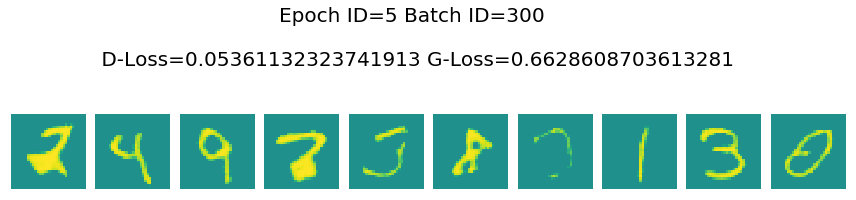

Epoch ID=5 Batch ID=400 

 D-Loss=0.12279609590768814 G-Loss=1.0226421356201172


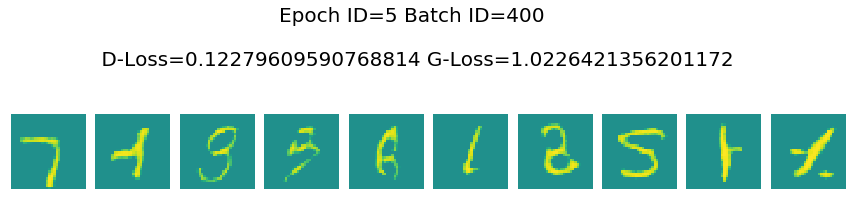

Epoch ID=5 Batch ID=500 

 D-Loss=0.2313835620880127 G-Loss=1.205256700515747


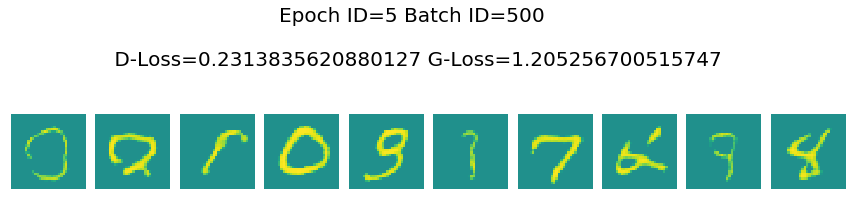

Epoch ID=5 Batch ID=600 

 D-Loss=0.11644183844327927 G-Loss=0.8815770745277405


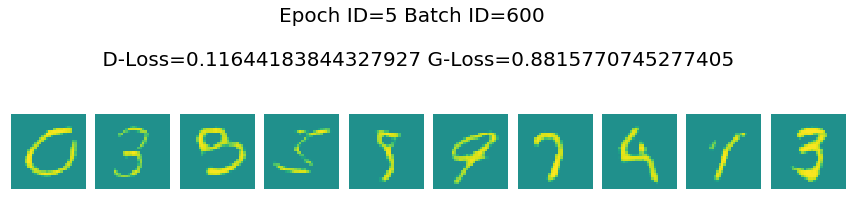

Epoch ID=5 Batch ID=700 

 D-Loss=0.06232085078954697 G-Loss=1.080909013748169


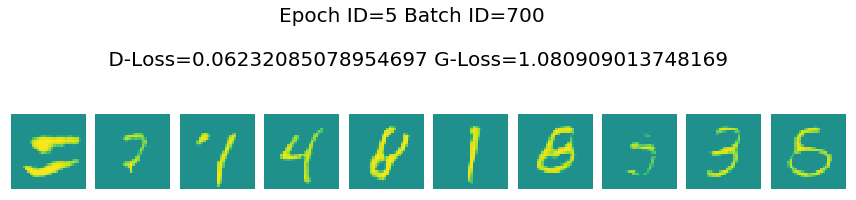

Epoch ID=5 Batch ID=800 

 D-Loss=0.18322935700416565 G-Loss=1.3428778648376465


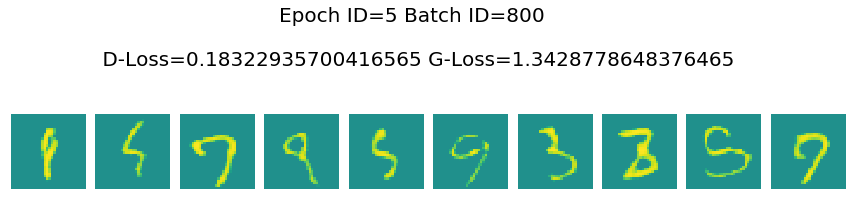

Epoch ID=5 Batch ID=900 

 D-Loss=0.0733446478843689 G-Loss=0.716827929019928


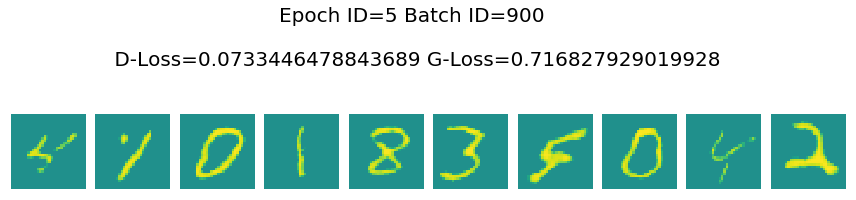

Epoch ID=5 Batch ID=1000 

 D-Loss=0.05889805406332016 G-Loss=0.7313905954360962


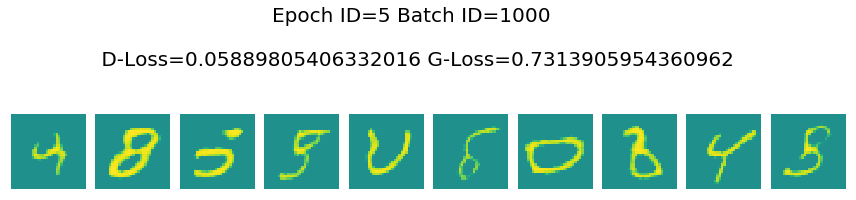

Epoch ID=5 Batch ID=1100 

 D-Loss=0.05507604777812958 G-Loss=0.6884868144989014


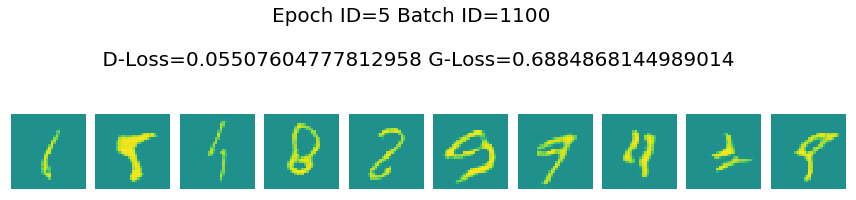

Epoch ID=5 Batch ID=1200 

 D-Loss=0.04618155211210251 G-Loss=0.9722776412963867


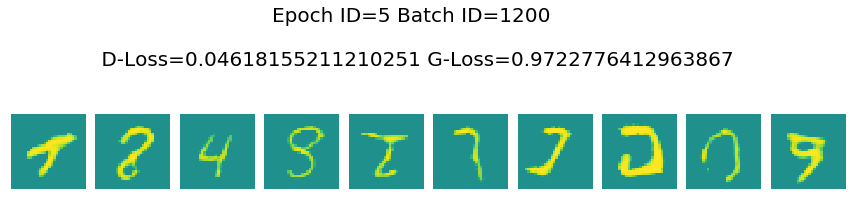

Epoch ID=5 Batch ID=1300 

 D-Loss=0.06433340907096863 G-Loss=1.3574806451797485


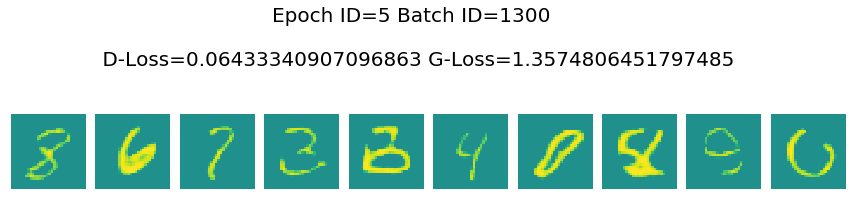

Epoch ID=5 Batch ID=1400 

 D-Loss=0.0619332492351532 G-Loss=1.0469757318496704


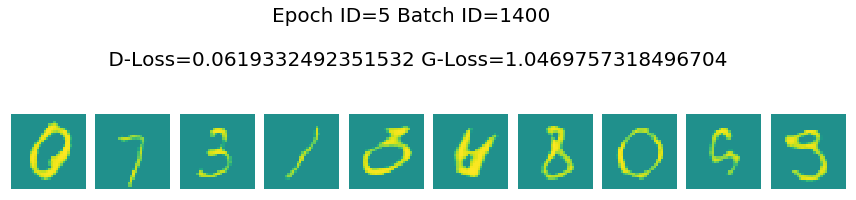

Epoch ID=5 Batch ID=1500 

 D-Loss=0.08374423533678055 G-Loss=0.624853253364563


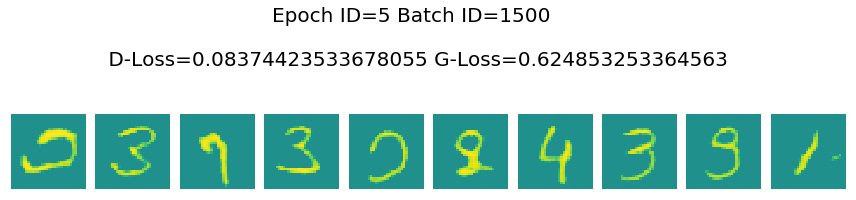

Epoch ID=5 Batch ID=1600 

 D-Loss=0.17713432013988495 G-Loss=1.12945556640625


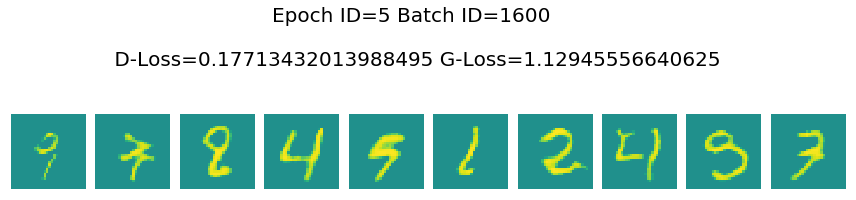

Epoch ID=5 Batch ID=1700 

 D-Loss=0.11488364636898041 G-Loss=0.9346279501914978


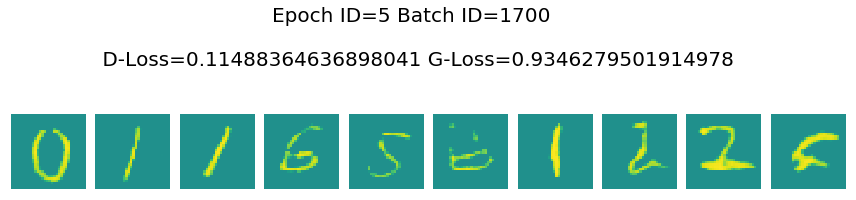

Epoch ID=5 Batch ID=1800 

 D-Loss=0.2190771847963333 G-Loss=0.8291541337966919


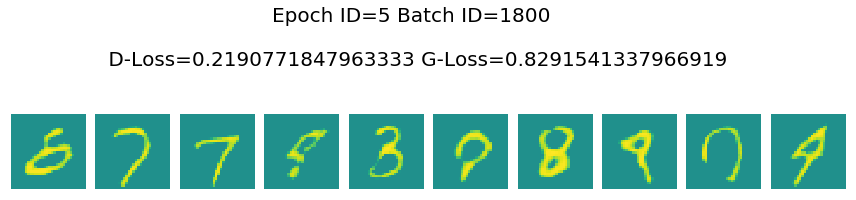

Epoch ID=6 Batch ID=0 

 D-Loss=0.05284136161208153 G-Loss=0.8668317794799805


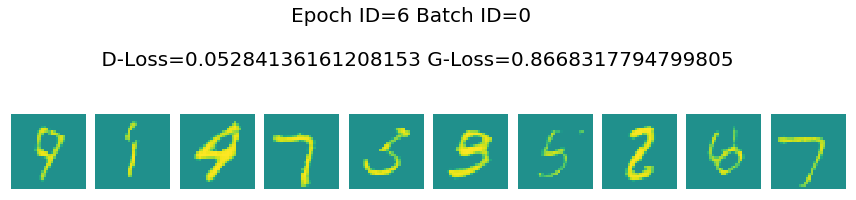

Epoch ID=6 Batch ID=100 

 D-Loss=0.05141016095876694 G-Loss=1.7125003337860107


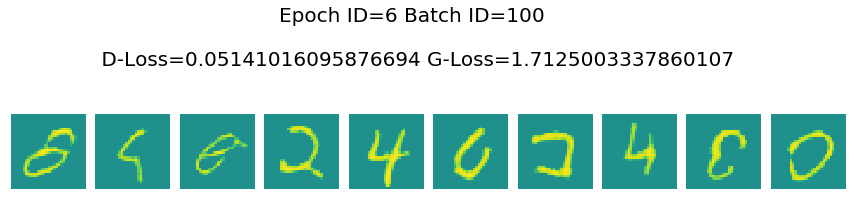

Epoch ID=6 Batch ID=200 

 D-Loss=0.033728718757629395 G-Loss=0.5805739164352417


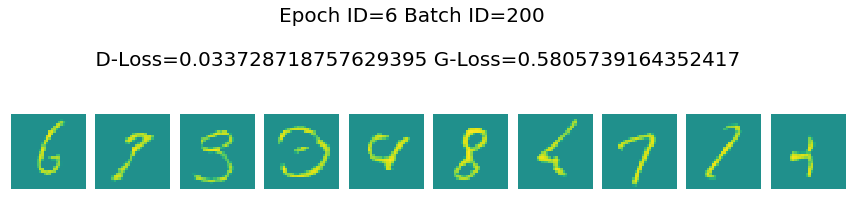

Epoch ID=6 Batch ID=300 

 D-Loss=0.027632594108581543 G-Loss=0.836531400680542


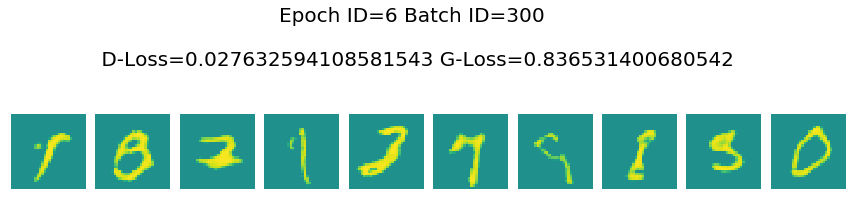

Epoch ID=6 Batch ID=400 

 D-Loss=0.20062460005283356 G-Loss=1.2074329853057861


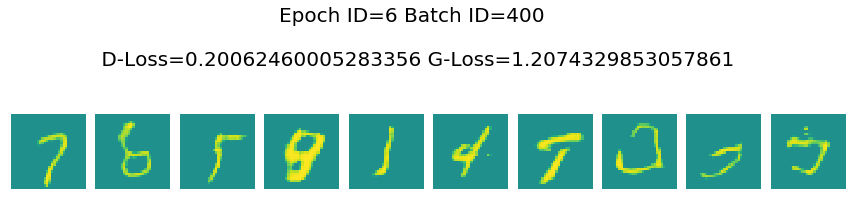

Epoch ID=6 Batch ID=500 

 D-Loss=0.10649638622999191 G-Loss=0.7799701690673828


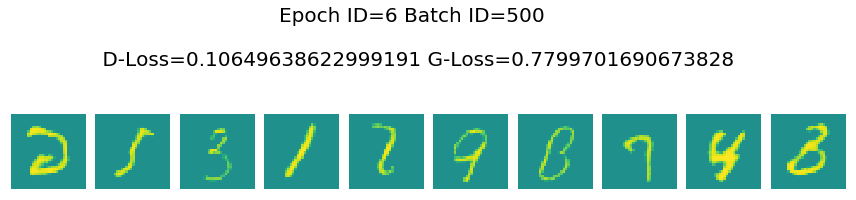

Epoch ID=6 Batch ID=600 

 D-Loss=0.04375524818897247 G-Loss=1.3589763641357422


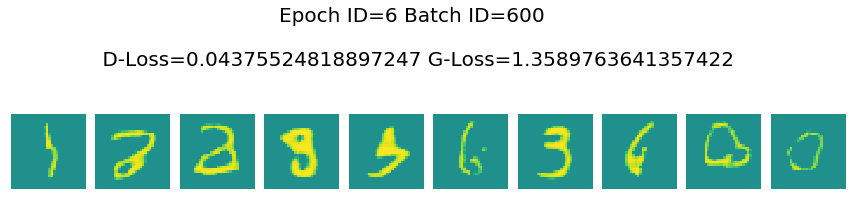

Epoch ID=6 Batch ID=700 

 D-Loss=0.16535162925720215 G-Loss=0.47115832567214966


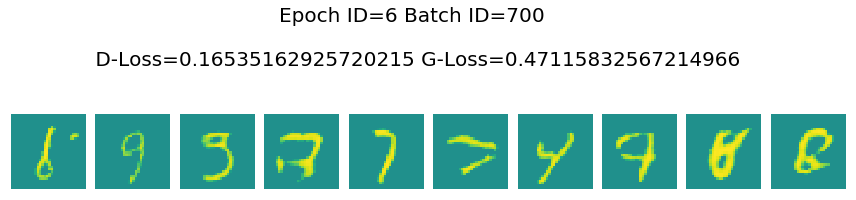

Epoch ID=6 Batch ID=800 

 D-Loss=0.04320184513926506 G-Loss=0.8904991149902344


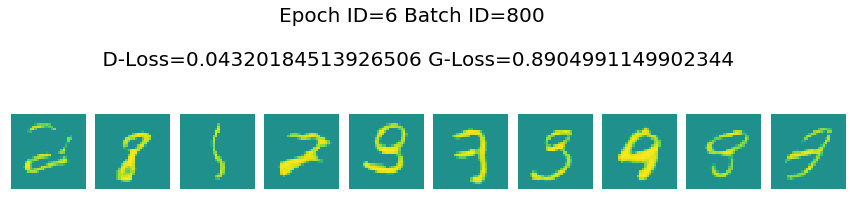

Epoch ID=6 Batch ID=900 

 D-Loss=0.030629418790340424 G-Loss=0.9619157314300537


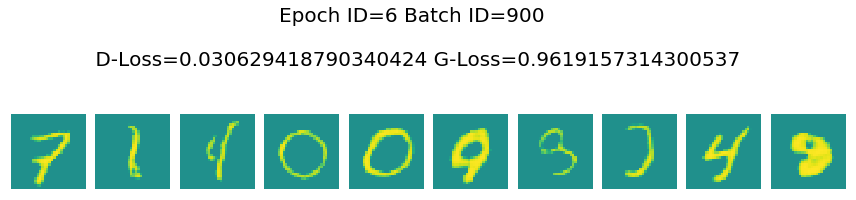

Epoch ID=6 Batch ID=1000 

 D-Loss=0.04178564250469208 G-Loss=1.1011972427368164


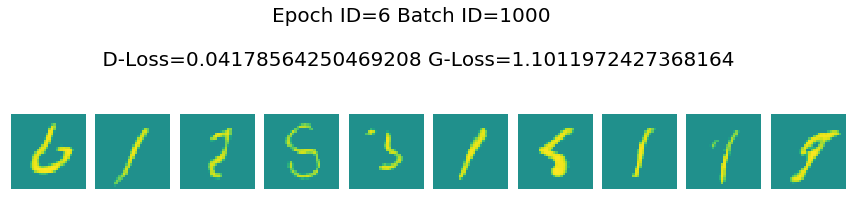

Epoch ID=6 Batch ID=1100 

 D-Loss=0.061500437557697296 G-Loss=1.0735467672348022


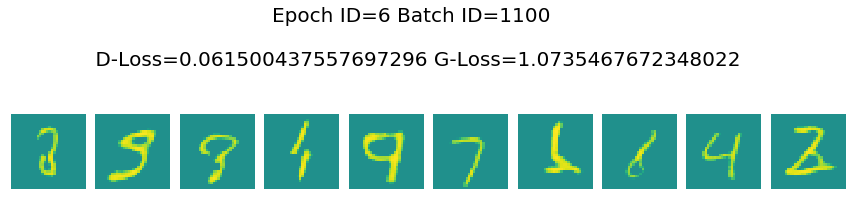

Epoch ID=6 Batch ID=1200 

 D-Loss=0.08398129045963287 G-Loss=0.7467722296714783


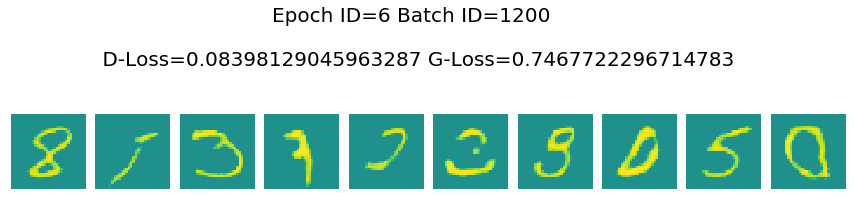

Epoch ID=6 Batch ID=1300 

 D-Loss=0.03396632894873619 G-Loss=0.8420315980911255


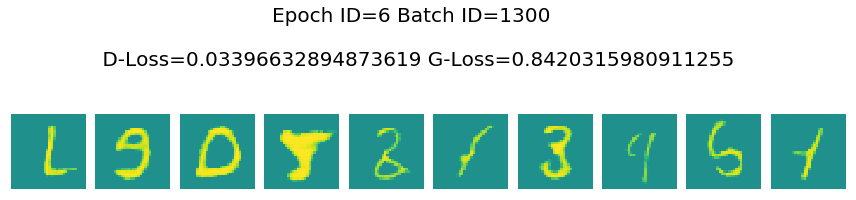

Epoch ID=6 Batch ID=1400 

 D-Loss=0.05730368196964264 G-Loss=0.6126054525375366


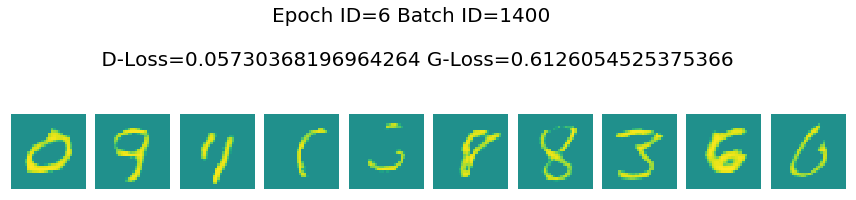

Epoch ID=6 Batch ID=1500 

 D-Loss=0.05794624239206314 G-Loss=0.9147118330001831


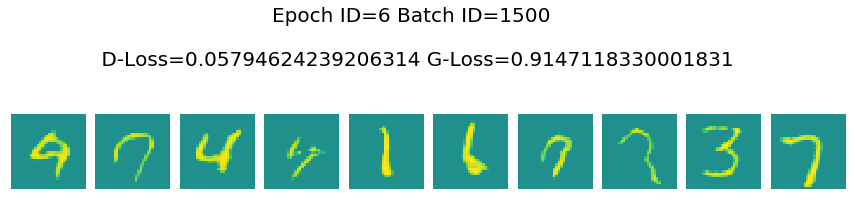

Epoch ID=6 Batch ID=1600 

 D-Loss=0.05237342789769173 G-Loss=0.920729398727417


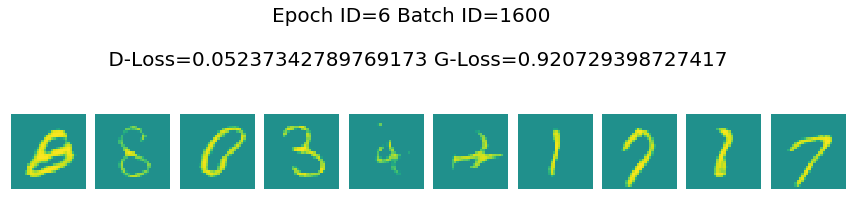

Epoch ID=6 Batch ID=1700 

 D-Loss=0.019017770886421204 G-Loss=0.6584088802337646


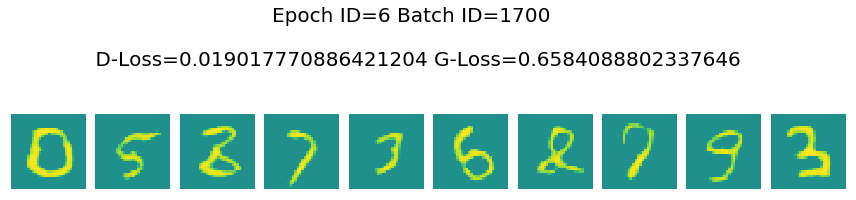

Epoch ID=6 Batch ID=1800 

 D-Loss=0.04280432313680649 G-Loss=0.8740028738975525


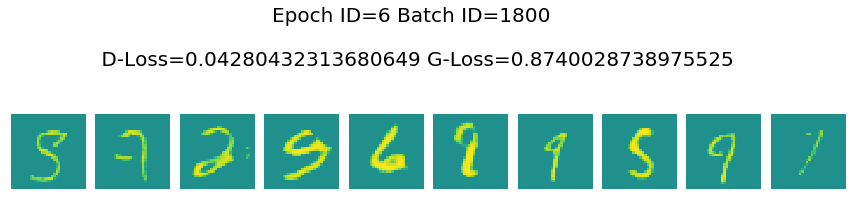

Epoch ID=7 Batch ID=0 

 D-Loss=0.050454750657081604 G-Loss=1.0568492412567139


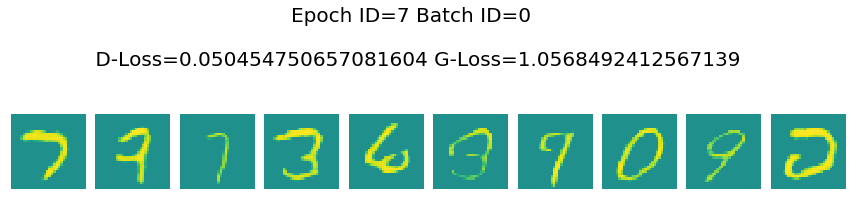

Epoch ID=7 Batch ID=100 

 D-Loss=0.02001582644879818 G-Loss=0.7544089555740356


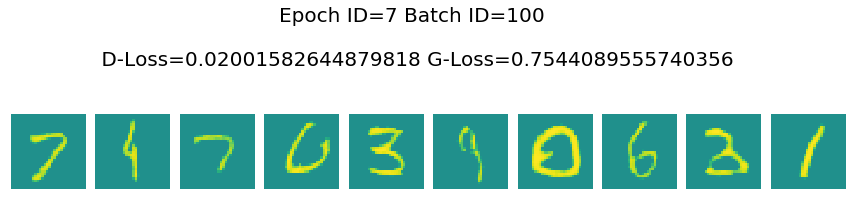

Epoch ID=7 Batch ID=200 

 D-Loss=0.024423064664006233 G-Loss=1.353574514389038


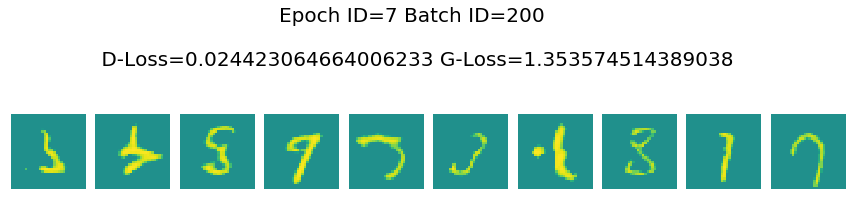

Epoch ID=7 Batch ID=300 

 D-Loss=0.028050962835550308 G-Loss=0.8933401703834534


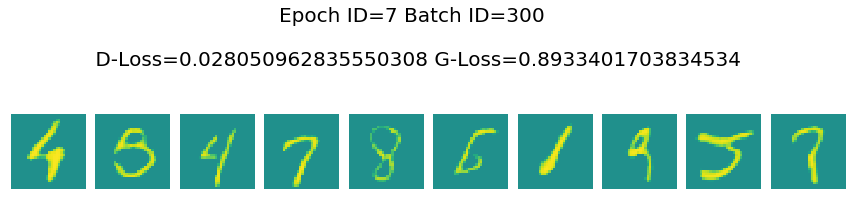

Epoch ID=7 Batch ID=400 

 D-Loss=0.022697802633047104 G-Loss=1.1616203784942627


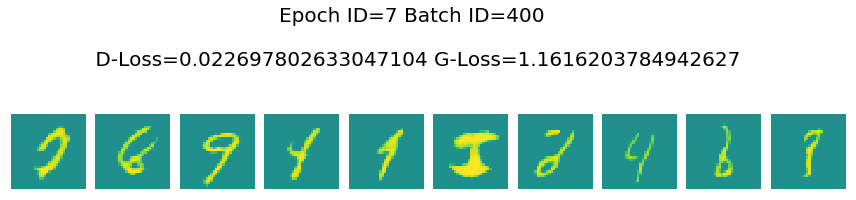

Epoch ID=7 Batch ID=500 

 D-Loss=0.037956513464450836 G-Loss=0.7089465856552124


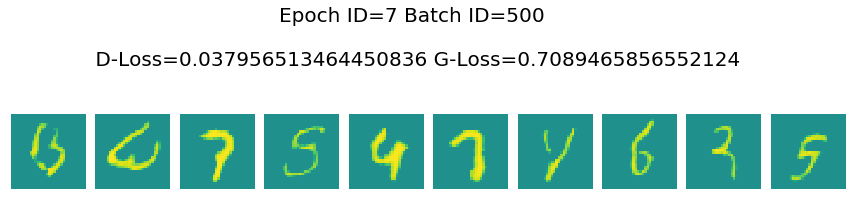

Epoch ID=7 Batch ID=600 

 D-Loss=0.07655222713947296 G-Loss=0.7471874952316284


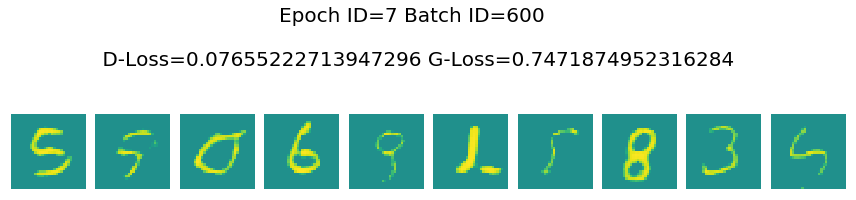

Epoch ID=7 Batch ID=700 

 D-Loss=0.02008746564388275 G-Loss=0.6655914783477783


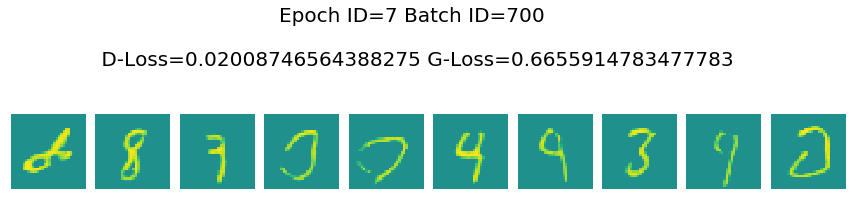

Epoch ID=7 Batch ID=800 

 D-Loss=0.07453161478042603 G-Loss=1.0549185276031494


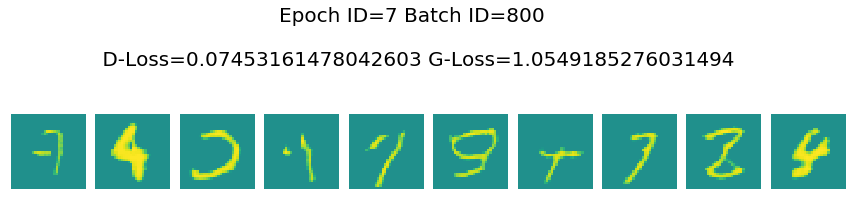

Epoch ID=7 Batch ID=900 

 D-Loss=0.016592562198638916 G-Loss=0.8389507532119751


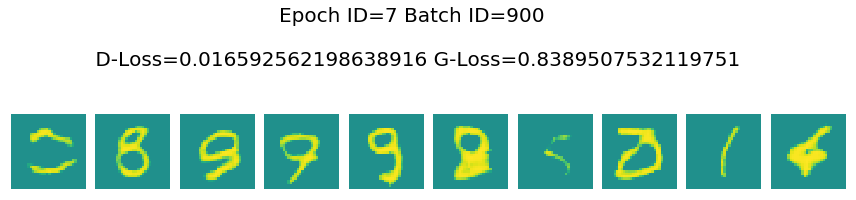

Epoch ID=7 Batch ID=1000 

 D-Loss=0.029261093586683273 G-Loss=1.2770425081253052


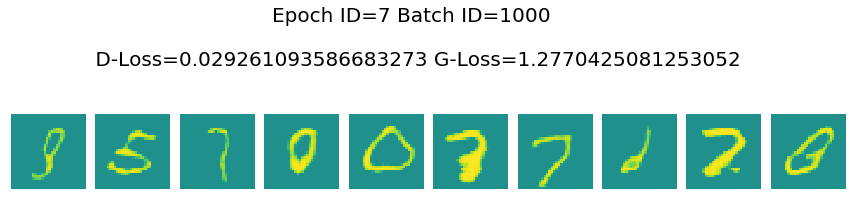

Epoch ID=7 Batch ID=1100 

 D-Loss=0.06458906829357147 G-Loss=0.8395094871520996


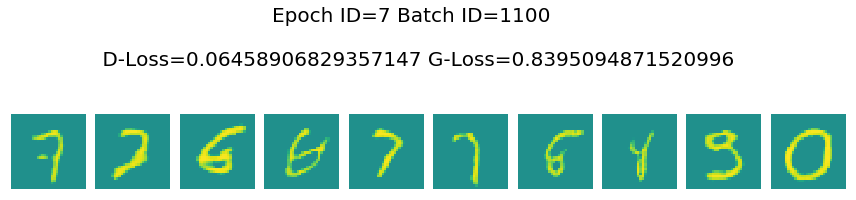

Epoch ID=7 Batch ID=1200 

 D-Loss=0.04180435091257095 G-Loss=0.808229923248291


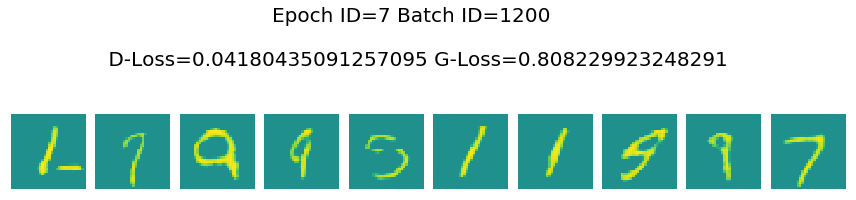

Epoch ID=7 Batch ID=1300 

 D-Loss=0.0326775386929512 G-Loss=0.7216490507125854


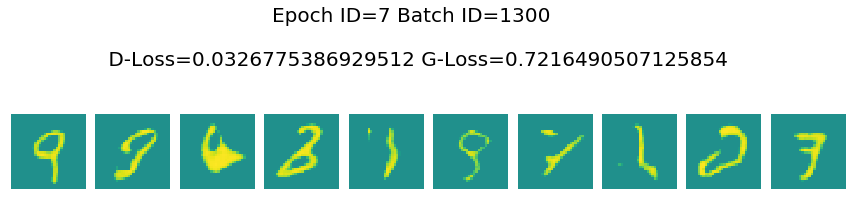

Epoch ID=7 Batch ID=1400 

 D-Loss=0.046607423573732376 G-Loss=0.7732177972793579


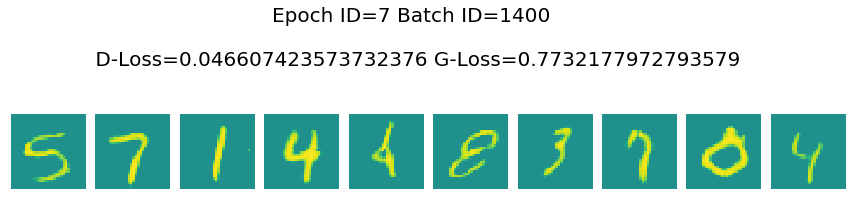

Epoch ID=7 Batch ID=1500 

 D-Loss=0.1707155853509903 G-Loss=1.1762669086456299


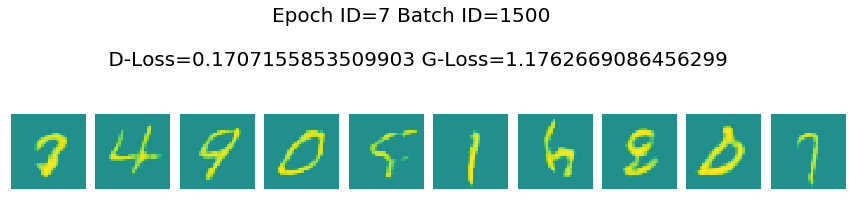

Epoch ID=7 Batch ID=1600 

 D-Loss=0.02162490040063858 G-Loss=0.9244496822357178


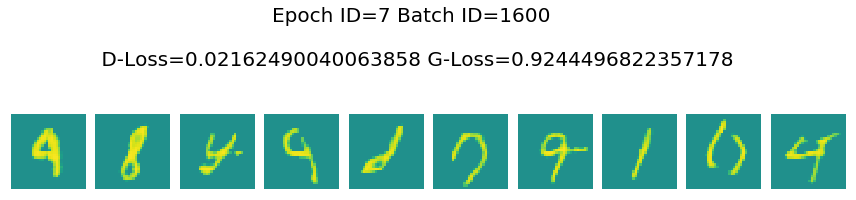

Epoch ID=7 Batch ID=1700 

 D-Loss=0.02184302732348442 G-Loss=1.3092877864837646


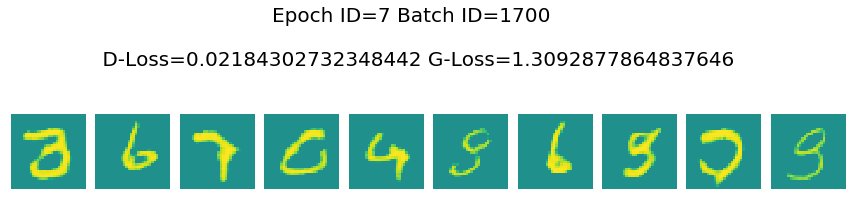

Epoch ID=7 Batch ID=1800 

 D-Loss=0.08346571773290634 G-Loss=1.0662556886672974


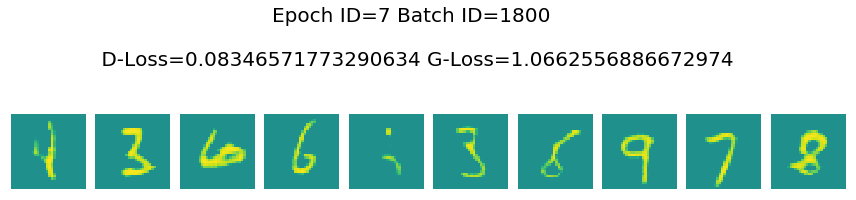

Epoch ID=8 Batch ID=0 

 D-Loss=0.1780647486448288 G-Loss=1.051147699356079


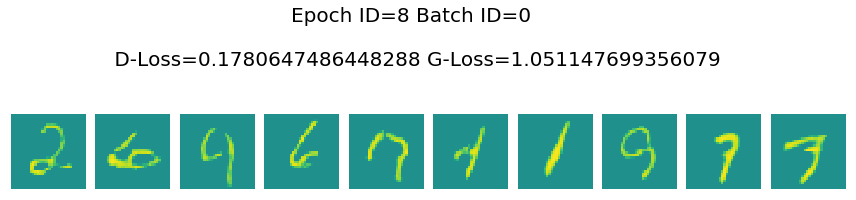

Epoch ID=8 Batch ID=100 

 D-Loss=0.01111135445535183 G-Loss=0.933292031288147


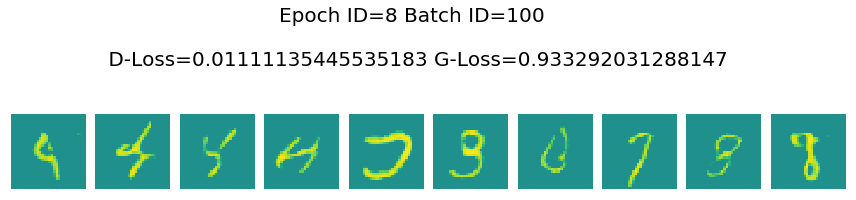

Epoch ID=8 Batch ID=200 

 D-Loss=0.1442122757434845 G-Loss=0.6141253709793091


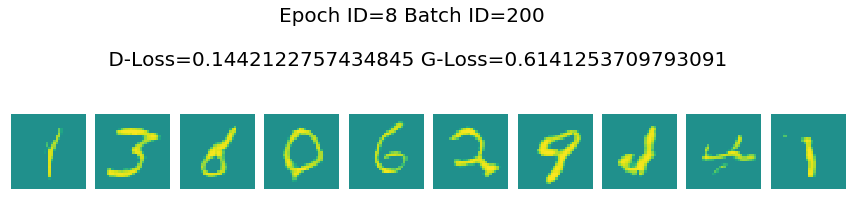

Epoch ID=8 Batch ID=300 

 D-Loss=0.08046886324882507 G-Loss=1.2070099115371704


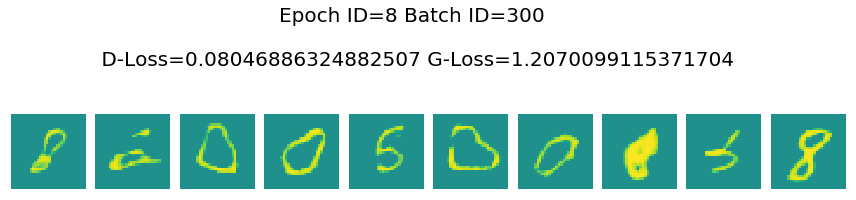

Epoch ID=8 Batch ID=400 

 D-Loss=0.01754477247595787 G-Loss=0.9004396200180054


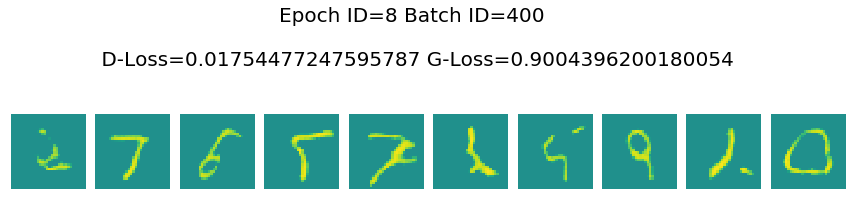

Epoch ID=8 Batch ID=500 

 D-Loss=0.07872043550014496 G-Loss=0.518821120262146


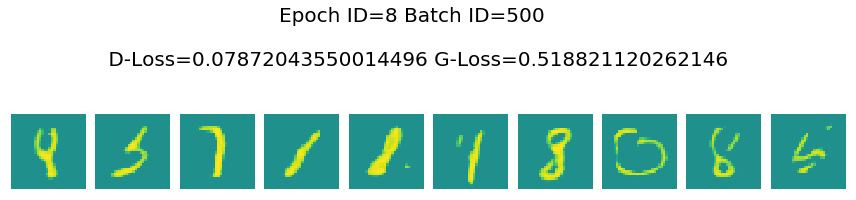

Epoch ID=8 Batch ID=600 

 D-Loss=0.06309561431407928 G-Loss=1.2408456802368164


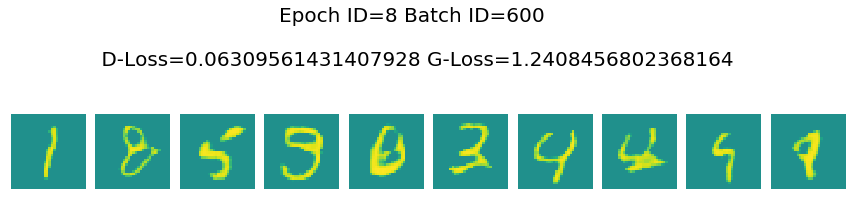

Epoch ID=8 Batch ID=700 

 D-Loss=0.032439619302749634 G-Loss=0.5882182121276855


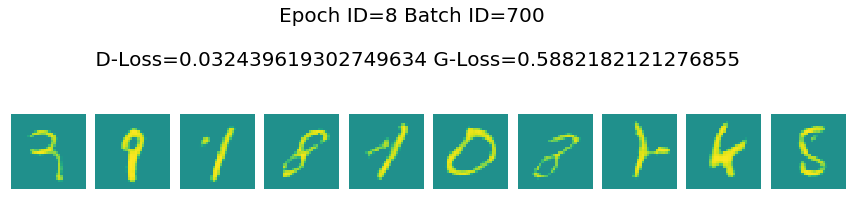

Epoch ID=8 Batch ID=800 

 D-Loss=0.18185630440711975 G-Loss=0.239592045545578


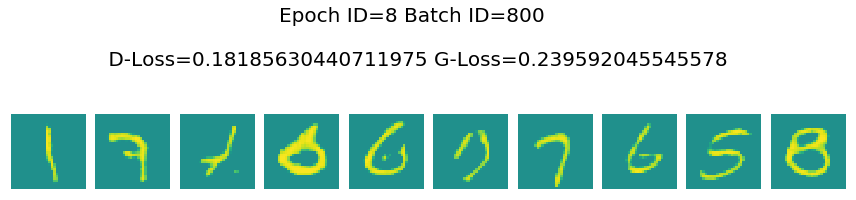

Epoch ID=8 Batch ID=900 

 D-Loss=0.026190586388111115 G-Loss=0.9292247295379639


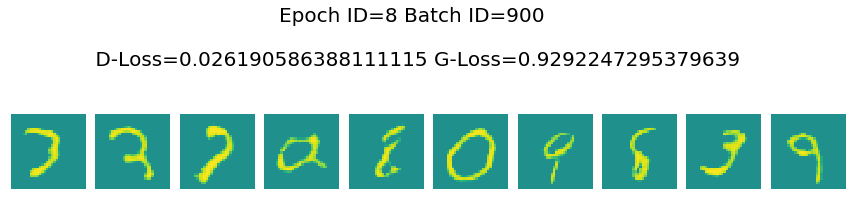

Epoch ID=8 Batch ID=1000 

 D-Loss=0.032319389283657074 G-Loss=0.6308309435844421


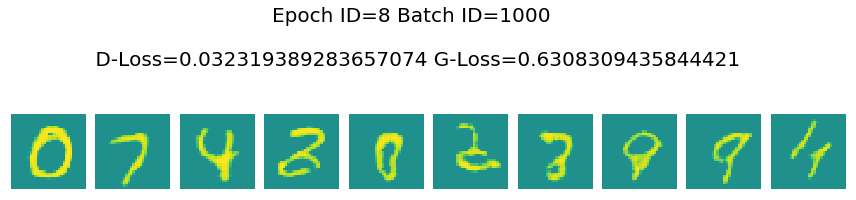

Epoch ID=8 Batch ID=1100 

 D-Loss=0.03813280165195465 G-Loss=0.7603455781936646


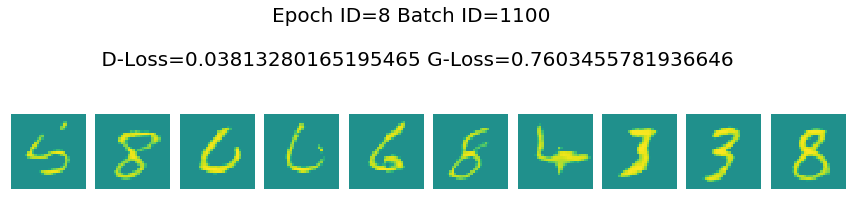

Epoch ID=8 Batch ID=1200 

 D-Loss=0.021869510412216187 G-Loss=0.9769755005836487


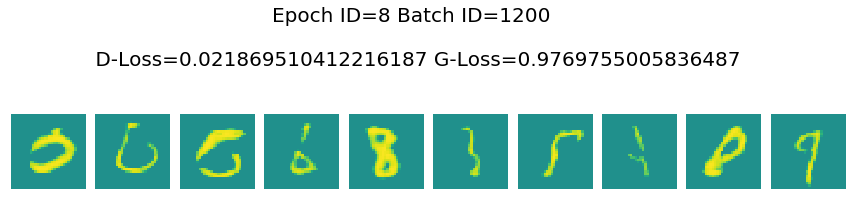

Epoch ID=8 Batch ID=1300 

 D-Loss=0.0122924679890275 G-Loss=1.048250675201416


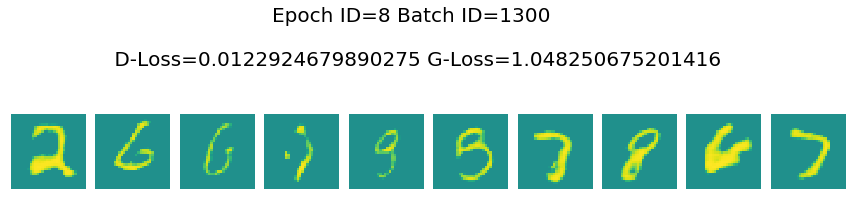

Epoch ID=8 Batch ID=1400 

 D-Loss=0.03876788169145584 G-Loss=1.4850507974624634


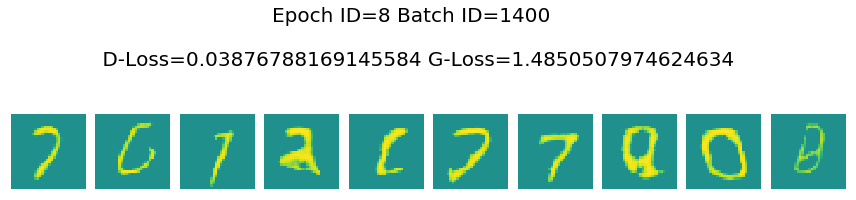

Epoch ID=8 Batch ID=1500 

 D-Loss=0.016197772696614265 G-Loss=1.2807321548461914


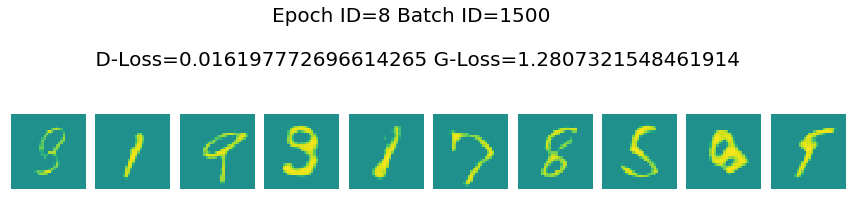

Epoch ID=8 Batch ID=1600 

 D-Loss=0.02580607868731022 G-Loss=1.0068159103393555


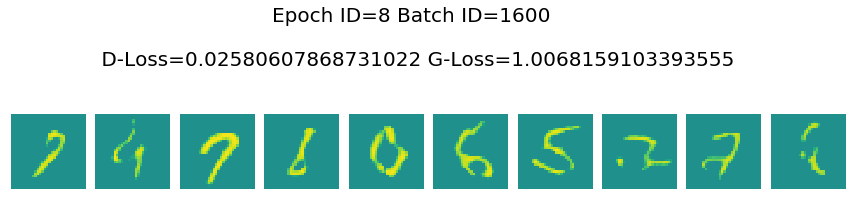

Epoch ID=8 Batch ID=1700 

 D-Loss=0.02386101894080639 G-Loss=0.9393200278282166


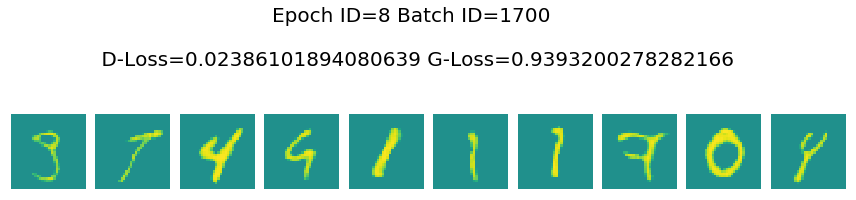

Epoch ID=8 Batch ID=1800 

 D-Loss=0.08265466243028641 G-Loss=1.3664166927337646


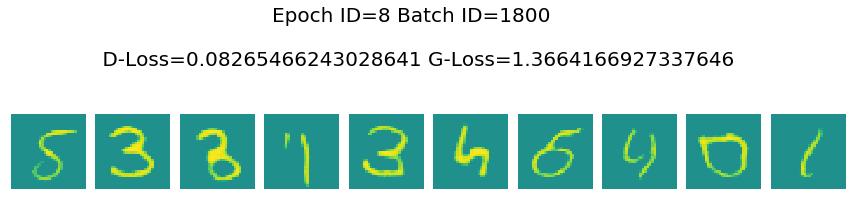

Epoch ID=9 Batch ID=0 

 D-Loss=0.22899270057678223 G-Loss=0.3703596591949463


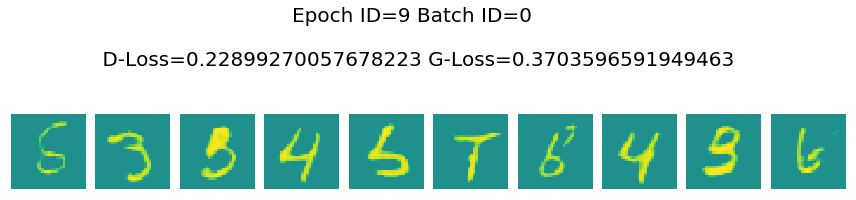

Epoch ID=9 Batch ID=100 

 D-Loss=0.06709021329879761 G-Loss=1.090012550354004


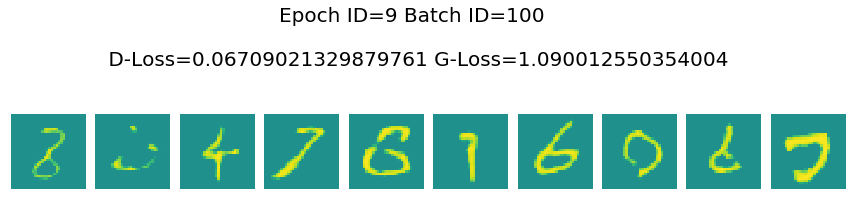

Epoch ID=9 Batch ID=200 

 D-Loss=0.029070058837532997 G-Loss=0.754324197769165


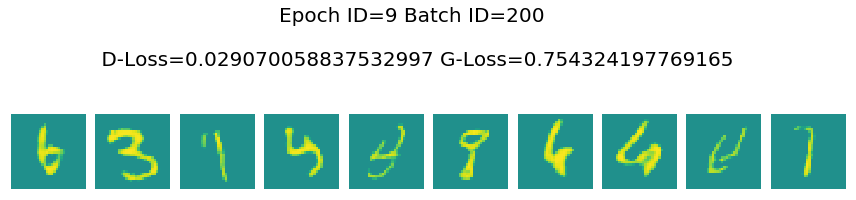

Epoch ID=9 Batch ID=300 

 D-Loss=0.011360063217580318 G-Loss=0.8959833979606628


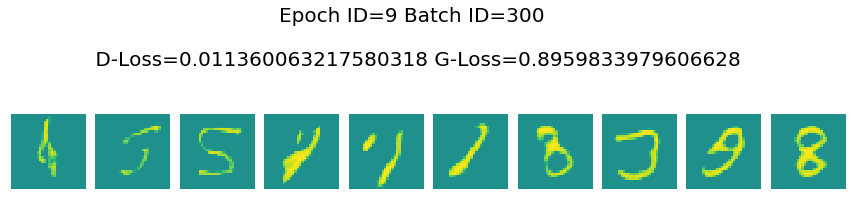

Epoch ID=9 Batch ID=400 

 D-Loss=0.05310063436627388 G-Loss=0.7184504866600037


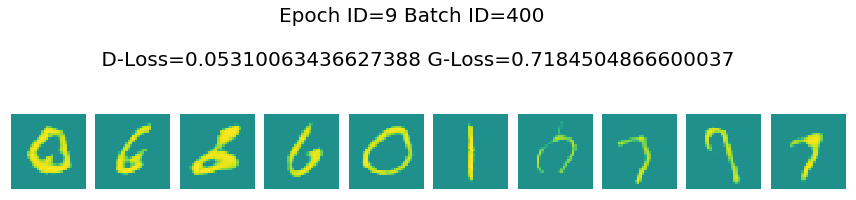

Epoch ID=9 Batch ID=500 

 D-Loss=0.10309472680091858 G-Loss=0.6079127788543701


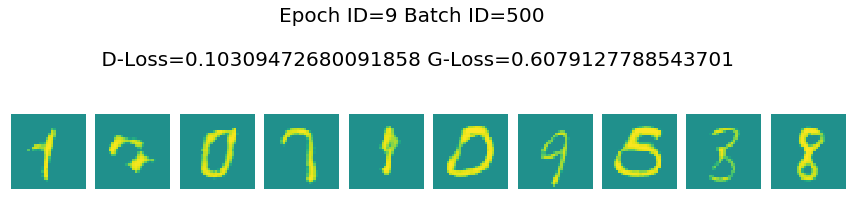

Epoch ID=9 Batch ID=600 

 D-Loss=0.029730163514614105 G-Loss=0.9044506549835205


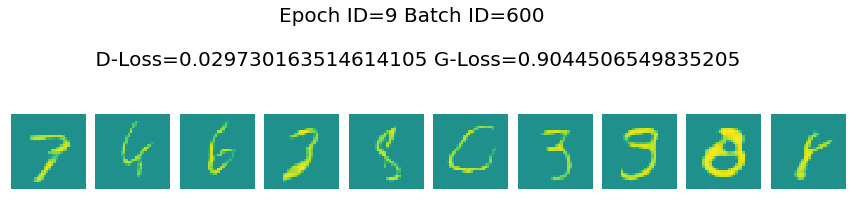

Epoch ID=9 Batch ID=700 

 D-Loss=0.027438579127192497 G-Loss=1.2972519397735596


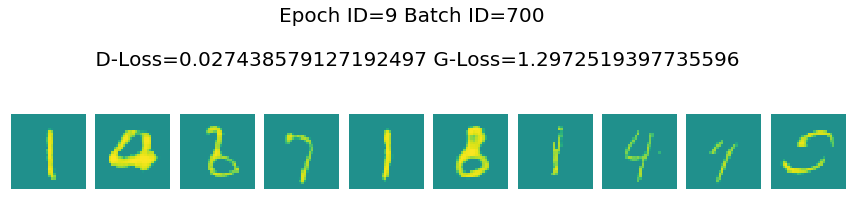

Epoch ID=9 Batch ID=800 

 D-Loss=0.10705460608005524 G-Loss=0.6744206547737122


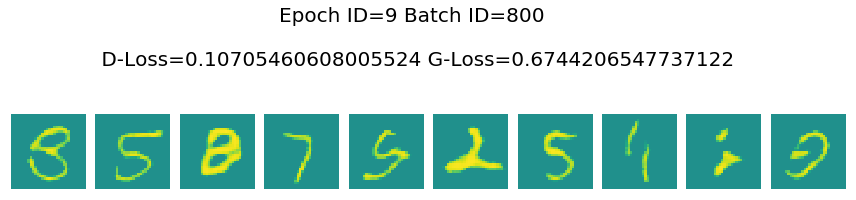

Epoch ID=9 Batch ID=900 

 D-Loss=0.2887178659439087 G-Loss=0.5887668132781982


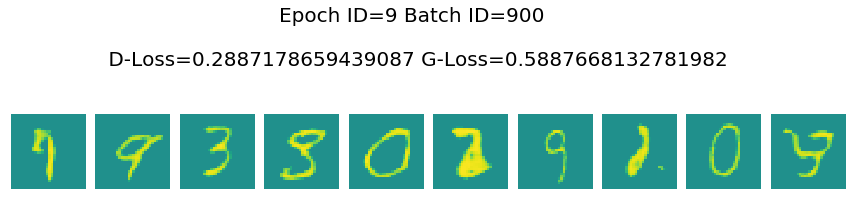

Epoch ID=9 Batch ID=1000 

 D-Loss=0.019809409976005554 G-Loss=1.065742015838623


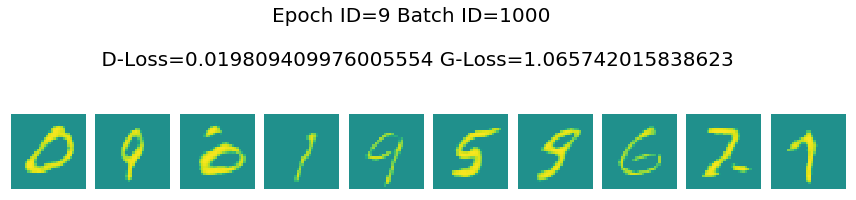

Epoch ID=9 Batch ID=1100 

 D-Loss=0.24415451288223267 G-Loss=0.572502076625824


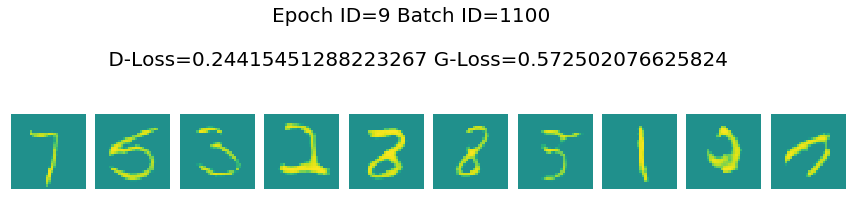

Epoch ID=9 Batch ID=1200 

 D-Loss=0.03249760717153549 G-Loss=1.1974496841430664


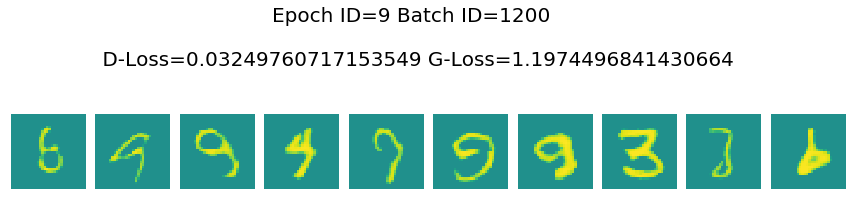

Epoch ID=9 Batch ID=1300 

 D-Loss=0.06430114060640335 G-Loss=1.137437343597412


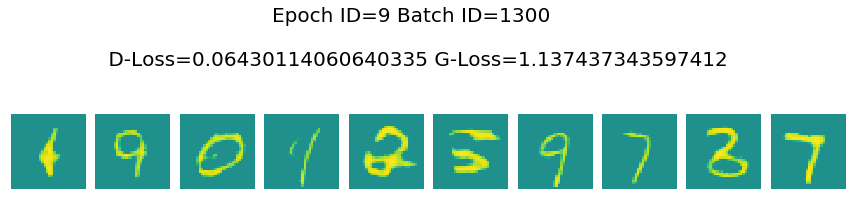

Epoch ID=9 Batch ID=1400 

 D-Loss=0.06221241503953934 G-Loss=0.8372484445571899


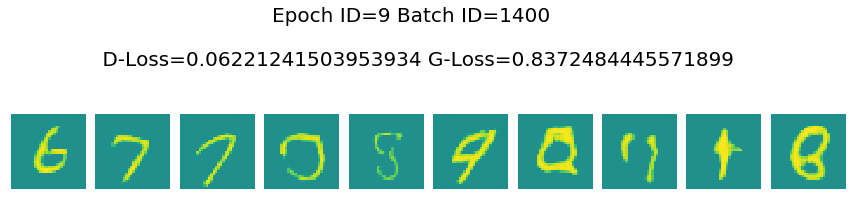

In [ ]:
losses = [[], []]
#plt.ion()
now = 0
for pass_id in range(100):
    for batch_id, (data, target) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        optimizerD.clear_grad()
        real_img = data
        bs_size = real_img.shape[0]
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype='float32')
        real_out = netD(real_img)
        errD_real = loss(real_out, label)
        # errD_real.backward()

        noise = paddle.randn([bs_size, 100, 1, 1], 'float32')
        fake_img = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), fake_label, dtype='float32')
        fake_out = netD(fake_img.detach())
        errD_fake = loss(fake_out,label)
        # errD_fake.backward()

        if loss.loss_name == 'wgan_gp_loss':
            gp = loss.gradient_penalty(real_img, fake_img, netD)
            # print(pass_id, batch_id, gp)
            errD = errD_real + errD_fake + gp
        else:
            errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        losses[0].append(errD.numpy()[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.clear_grad()
        noise = paddle.randn([bs_size, 100, 1, 1],'float32')
        fake = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()

        losses[1].append(errG.numpy()[0])


        ############################
        # visualize
        ###########################
        if batch_id % 100 == 0:
            generated_image = netG(noise).numpy()
            imgs = []
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    image = generated_image[i].transpose()
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,0,2))
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                if loss.loss_name == 'wgan_gp_loss':
                    msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3} GP={4}'.format(pass_id, batch_id, errD.numpy()[0], errG.numpy()[0], gp.numpy()[0])
                else:
                    msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id, batch_id, errD.numpy()[0], errG.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', pass_id, batch_id), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
        # break
    # break
    paddle.save(netG.state_dict(), "work/generator.params")

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 